In [1]:
'''
Waterfowl energetics model
October 2023
Mike Mitchell - mmitchell@ducks.org - Ducks Unlimited

Duckdb
'''
baseaoiurl = 'https://giscog.blob.core.windows.net/waterfowlmodel/'
aois = ['ARmav', 'ARwg', 'KY', 'LAmav', 'LAwg', 'MO', 'MS', 'OK', 'TN', 'TX'] # used to read in files. example: baseaoiurl+aoi+'daily_obj3.csv'
removewater = False # Removes OpenWater
customcurves = True
smoothcrops = True
spatialhandledeficit = True

# Start date: October 1st of a given year
start_date = "Aug 1 2023"

# Habitat curve should be in percentages and max shouldn't be more than 100.
cropcurvedata = {
                    'EmergentWetlands':[19,89,100],
                    'WoodyWetlands':[2,89,100],
                    'OpenWater':[100,100,100],
                    'Sorghum':[3,100,30],
                    'Corn':[3,100,27],
                    'Soybeans':[5,100,38],
                    'Rice':[9,100,39],
                    'Aquaculture':[34,94,100],
                    'Millet':[46,100,95],
                    'Dbl Crop Corn/Soybeans':[2,100,28]
                }
# Decomposition rates as a daily percent decay.  To be calculated by day as leftover = leftover * (100-decay)
cropdecomp = {
                    'EmergentWetlands':0.18,
                    'WoodyWetlands':0.0037,
                    'OpenWater':0,
                    'Sorghum':0.322,
                    'Corn':1.57,
                    'Soybeans':1.9,
                    'Rice':0.213,
                    'Aquaculture':0,
                    'Millet':0.64,
                    'Dbl Crop Corn/Soybeans':1.9
                }
customcurvesdict = {
                    'Arkansas_mav_MALL': [0,0.027916566,0.056929146,0.448400933,0.111111111,0.555555556,1,0.888888889,0.444444444,0.120744769],
                    'Arkansas_mav_Other': [0,0.186634469,0.288705009,0.72791718,0.37037037,0.740740741,0.962962963,1,0.5,0.542658406],
                    'Louisiana_mav_MALL': [0,0.04,0.52,0.80,1.00,0.51,0.20,],
                    'Louisiana_mav_Other': [0,0.38,0.59,0.93,1.00,1.00,0.63,]
                   }

energycsvurl = 'https://giscog.blob.core.windows.net/waterfowlmodel/4D_LMVJV-ST_Obj_FINAL_LONG2.csv'


In [2]:
##########################################
# All config above this line
##########################################

In [3]:
# Checks to make sure habitat curves have at least 3 values and they are not > 100%        
for key,val in cropcurvedata.items():
    if max(val) >100:
        print('Value in {} has a value greater than 100'.format(key))
    if len(val) <3:
        print('Not a great curve with < 3 values for {}'.format(key))

if removewater:
    if 'OpenWater'in cropcurvedata:
        del cropcurvedata['OpenWater']


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
import sys
import pandas as pd
import json, requests
import geopandas as gpd
import shapely
import duckdb
from shapely import wkt, wkb
import matplotlib.ticker as ticker
from datetime import datetime, timedelta
#import pygeos as pg

#pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.float_format', lambda x : "{:,.2f}".format(x))
# Generate 228 dates starting from October 1st
start_date = datetime.strptime(start_date, "%b %d %Y")
date_labels = [(start_date + timedelta(days=i)).strftime("%b_%d") for i in range(228)]

In [5]:
con = duckdb.connect()
con.install_extension("spatial")
con.load_extension("spatial")
con.install_extension("azure")
con.load_extension("azure")

In [6]:
##########################################
#
# Setup done
#
##########################################

In [7]:
con.sql('''
CREATE OR REPLACE TABLE lmvjvwaterfowlenergy AS SELECT * FROM read_parquet('D:\source\waterfowl\waterfowlenergynotebook\lmvjvwaterfowlenergy.parquet')
''')

In [8]:
tocrs = '5070'
aoiquery = 'https://services2.arcgis.com/5I7u4SJE1vUr79JC/ArcGIS/rest/services/LMVJV_Boundary/FeatureServer/0/query?where=1%3D1&objectIds=&time=&geometry=&geometryType=esriGeometryEnvelope&inSR=&spatialRel=esriSpatialRelIntersects&resultType=none&distance=0.0&units=esriSRUnit_Meter&relationParam=&returnGeodetic=false&outFields=&returnGeometry=true&returnCentroid=false&featureEncoding=esriDefault&multipatchOption=xyFootprint&maxAllowableOffset=&geometryPrecision=&outSR={0}&defaultSR=&datumTransformation=&applyVCSProjection=false&returnIdsOnly=false&returnUniqueIdsOnly=false&returnCountOnly=false&returnExtentOnly=false&returnQueryGeometry=false&returnDistinctValues=false&cacheHint=false&orderByFields=&groupByFieldsForStatistics=&outStatistics=&having=&resultOffset=&resultRecordCount=&returnZ=false&returnM=false&returnExceededLimitFeatures=true&quantizationParameters=&sqlFormat=none&f=pgeojson&token='.format(tocrs)
r = json.dumps(requests.get(aoiquery).json())
aoiresult = gpd.read_file(r)
aoibounds = list(aoiresult.bounds.values[0])

#incounty = 'https://services.arcgis.com/P3ePLMYs2RVChkJx/ArcGIS/rest/services/USA_Counties/FeatureServer/0/query?where=1%3D1&objectIds=&time=&geometry={0}&geometryType=esriGeometryEnvelope&inSR=5070&spatialRel=esriSpatialRelIntersects&resultType=none&distance=0.0&units=esriSRUnit_Meter&relationParam=&returnGeodetic=false&outFields=*&returnGeometry=true&returnCentroid=false&featureEncoding=esriDefault&multipatchOption=xyFootprint&maxAllowableOffset=&geometryPrecision=&outSR=5070&defaultSR=&datumTransformation=&applyVCSProjection=false&returnIdsOnly=false&returnUniqueIdsOnly=false&returnCountOnly=false&returnExtentOnly=false&returnQueryGeometry=false&returnDistinctValues=false&cacheHint=false&orderByFields=&groupByFieldsForStatistics=&outStatistics=&having=&resultOffset=&resultRecordCount=&returnZ=false&returnM=false&returnExceededLimitFeatures=true&quantizationParameters=&sqlFormat=none&f=pgeojson&token='.format(', '.join(str(a) for a in aoibounds))
#r = json.dumps(requests.get(incounty).json())
#county = gpd.read_file(r)
#county = county[['FIPS','NAME', 'STATE_NAME', 'geometry']]
con.sql('''CREATE OR REPLACE TABLE cnty AS SELECT FIPS, NAME, STATE_NAME, geometry FROM read_parquet('https://giscog.blob.core.windows.net/abdu/uscounties.parquet') 
            WHERE ST_Intersects(geometry, ST_MakeEnvelope({0},{1},{2},{3}))'''.format(aoibounds[0],aoibounds[1],aoibounds[2],aoibounds[3]))

inbcr = 'https://gisweb.ducks.org/server/rest/services/GEODATA/BCR/FeatureServer/0/query?where=1%3D1&objectIds=&time=&geometry=&geometryType=esriGeometryEnvelope&inSR=&spatialRel=esriSpatialRelIntersects&distance=&units=esriSRUnit_Foot&relationParam=&outFields=*&returnGeometry=true&maxAllowableOffset=&geometryPrecision=&outSR=5070&havingClause=&gdbVersion=&historicMoment=&returnDistinctValues=false&returnIdsOnly=false&returnCountOnly=false&returnExtentOnly=false&orderByFields=&groupByFieldsForStatistics=&outStatistics=&returnZ=false&returnM=false&multipatchOption=xyFootprint&resultOffset=&resultRecordCount=&returnTrueCurves=false&returnExceededLimitFeatures=false&quantizationParameters=&returnCentroid=false&timeReferenceUnknownClient=false&sqlFormat=none&resultType=&featureEncoding=esriDefault&datumTransformation=&f=geojson'
r = json.dumps(requests.get(inbcr).json())
bcr = gpd.read_file(r)

In [9]:
bcr['geometry'] = bcr.to_wkb().geometry

C:\Users\mmitchell.DUCKS\AppData\Local\Temp\ipykernel_25564\96820694.py:1: UserWarning: Geometry column does not contain geometry.
  bcr['geometry'] = bcr.to_wkb().geometry


In [10]:
con.sql('''CREATE OR REPLACE TABLE bcr AS SELECT * EXCLUDE geometry, st_geomfromWKB(geometry) as geometry FROM bcr''')
con.sql('''CREATE OR REPLACE TABLE bcr AS SELECT BCR, BCRNAME, geometry FROM bcr''')

In [11]:
con.sql('''CREATE OR REPLACE TABLE statebcr AS 
SELECT NAME, FIPS, STATE_NAME, BCR, BCRNAME, ST_Intersection(cnty.geometry, bcr.geometry) as geometry
FROM cnty
JOIN
bcr ON ST_Intersects(cnty.geometry, bcr.geometry)
''')


In [12]:
con.sql(
    """
        CREATE OR REPLACE TABLE statebcrenergy AS 
        SELECT c.FIPS, c.NAME, c.STATE_NAME, c.BCR, c.BCRNAME, e.CLASS, e.ValueLo, e.ValueHi, ST_Intersection(e.geometry, c.geometry) as geometry
        FROM lmvjvwaterfowlenergy AS e, statebcr AS c
        WHERE ST_Intersects(e.geometry, c.geometry)
    """
)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [13]:
##################################################
#
# Continue
#
##################################################
duckdb.__version__

'1.3.0'

In [14]:
# Read in energy layer
#gdf.to_parquet('energylayerintersect.parquet')
inenergyread = con.sql('select * exclude geometry, ST_AsText(geometry) as geometry from statebcrenergy').df()

In [15]:
inenergy = inenergyread.copy()
inenergy['geometry'] = inenergy['geometry'].apply(wkt.loads)
inenergy = gpd.GeoDataFrame(inenergy, geometry='geometry', crs=5070)
inenergy = inenergy.rename(columns={'Class':'CLASS'})
inenergy.head()

FIPS   NAME STATE_NAME  BCR                            BCRNAME  \
0  48037  Bowie      Texas   25  WEST GULF COASTAL PLAIN/OUACHITAS   
1  48037  Bowie      Texas   25  WEST GULF COASTAL PLAIN/OUACHITAS   
2  48037  Bowie      Texas   25  WEST GULF COASTAL PLAIN/OUACHITAS   
3  48037  Bowie      Texas   25  WEST GULF COASTAL PLAIN/OUACHITAS   
4  48037  Bowie      Texas   25  WEST GULF COASTAL PLAIN/OUACHITAS   

                 CLASS  ValueLo  ValueHi  \
0  Herbaceous Wetlands      247     1622   
1                 Rice     1099    16044   
2             Soybeans      937     3410   
3  Herbaceous Wetlands      247     1622   
4                 Corn     1130    22530   

                                            geometry  
0  POLYGON ((148755 1166595, 148785 1166595, 1487...  
1  POLYGON ((166215 1166595, 166245 1166595, 1662...  
2  POLYGON ((168435 1166595, 168435 1166565, 1684...  
3  POLYGON ((148725 1166565, 148755 1166565, 1487...  
4  POLYGON ((148785 1166535, 148785 1166565, 1487...

In [16]:
'''
Prep energy layer so we can calculate total energy at the county level.  Remove NAN
'''
#inenergy = inenergy.set_crs(5070)
inenergy['acres'] = inenergy.area* 0.000247105
inenergy.loc[inenergy.CLASS=='Woody Wetlands', ['CLASS']] = 'WoodyWetlands'
inenergy.loc[inenergy.CLASS=='Open Water', ['CLASS']] = 'OpenWater'
inenergy.loc[inenergy.CLASS=='Herbaceous Wetlands', ['CLASS']] = 'EmergentWetlands'
inenergy = inenergy.drop(['geometry'], axis=1)
inenergy = inenergy.groupby(['FIPS','NAME','STATE_NAME','BCR','BCRNAME','CLASS','ValueLo','ValueHi']).sum()
inenergy = inenergy.reset_index()
inenergy = inenergy[inenergy['NAME']!='NaN']
inenergy.loc[(inenergy['STATE_NAME']=='Arkansas') & (inenergy['BCRNAME']=='MISSISSIPPI ALLUVIAL VALLEY'), ['statebcr']] = 'Arkansas_mav'
inenergy.loc[(inenergy['STATE_NAME']=='Arkansas') & (inenergy['BCRNAME']=='WEST GULF COASTAL PLAIN/OUACHITAS'), ['statebcr']] = 'Arkansas_wg'
inenergy.loc[(inenergy['STATE_NAME']=='Louisiana') & (inenergy['BCRNAME']=='MISSISSIPPI ALLUVIAL VALLEY'), ['statebcr']] = 'Louisiana_mav'
inenergy.loc[(inenergy['STATE_NAME']=='Louisiana') & (inenergy['BCRNAME']=='WEST GULF COASTAL PLAIN/OUACHITAS'), ['statebcr']] = 'Louisiana_wg'
inenergy.loc[~inenergy['STATE_NAME'].isin(['Arkansas', 'Louisiana']), ['statebcr']] = inenergy['STATE_NAME']
inenergy = inenergy.drop(['STATE_NAME','BCR','BCRNAME'], axis=1)

C:\Users\mmitchell.DUCKS\AppData\Local\Temp\ipykernel_25564\4131605805.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Arkansas_mav' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  inenergy.loc[(inenergy['STATE_NAME']=='Arkansas') & (inenergy['BCRNAME']=='MISSISSIPPI ALLUVIAL VALLEY'), ['statebcr']] = 'Arkansas_mav'


In [17]:
print('Acres')
print(inenergy.groupby('statebcr')['acres'].sum())
inenergy['kcalLo'] = inenergy['acres']*inenergy['ValueLo']
print('')
print('kcal Lo')
print(inenergy.groupby('statebcr')['kcalLo'].sum())

Acres
statebcr
Arkansas_mav    1,278,468.97
Arkansas_wg       590,228.62
Illinois           12,661.44
Kentucky           39,899.18
Louisiana_mav   1,770,618.02
Louisiana_wg      749,647.19
Mississippi       742,068.75
Missouri          322,430.55
Oklahoma          255,472.07
Tennessee         115,559.41
Texas             873,334.99
Name: acres, dtype: float64

kcal Lo
statebcr
Arkansas_mav    1,018,753,360.25
Arkansas_wg        84,717,085.52
Illinois            5,246,850.20
Kentucky           12,261,805.14
Louisiana_mav     384,020,103.54
Louisiana_wg       87,365,618.57
Mississippi       336,246,460.28
Missouri          268,664,705.22
Oklahoma           14,177,636.51
Tennessee          34,496,161.77
Texas              60,041,394.44
Name: kcalLo, dtype: float64


In [18]:
print('Habitat acres: {0:,.0f}'.format(inenergy['acres'].sum()))
print('Total kcal: {0:,.0f}'.format((inenergy['acres']*inenergy['ValueLo']).sum()))

Habitat acres: 6,771,859
Total kcal: 2,310,689,650


In [19]:
# Read population objectives
popobjtable = pd.read_csv(energycsvurl)
popobjtable = popobjtable.rename(columns={'State':'state', 'LMVJV.80P.OBJ':'popobj80'})
print('Max population objective: {0:,.0f}'.format(popobjtable['popobj80'].max()))
print('Sum population objective: {0:,.0f}'.format(popobjtable['popobj80'].sum()))
popobjtable.groupby('state')['popobj80'].sum()

Max population objective: 2,672,079
Sum population objective: 12,705,194


state
Arkansas_mav    5,303,882.29
Arkansas_wg     1,731,317.98
Kentucky           74,751.00
Louisiana_mav   1,613,806.25
Louisiana_wg    1,259,193.02
Mississippi     1,282,635.00
Missouri          263,451.00
Oklahoma          162,801.00
Tennessee         252,025.00
Texas             761,331.00
Name: popobj80, dtype: float64

In [20]:
# Read waterfowl curves and adjust attributes to align with long term objectives by statebcr
mergecurve = pd.DataFrame()
for aoi in aois:
    incsv = pd.read_csv(baseaoiurl+aoi+'daily_obj3.csv')
    mergecurve = pd.concat([mergecurve, incsv])
mergecurve = mergecurve.rename(columns={'ST':'state','SP2':'species'})
mergecurve.loc[mergecurve.state=='ARmav', ['state']] = 'Arkansas_mav'
mergecurve.loc[mergecurve.state=='ARwg', ['state']] = 'Arkansas_wg'
mergecurve.loc[mergecurve.state=='KY', ['state']] = 'Kentucky'
mergecurve.loc[mergecurve.state=='LAwg', ['state']] = 'Louisiana_wg'
mergecurve.loc[mergecurve.state=='LAmav', ['state']] = 'Louisiana_mav'
mergecurve.loc[mergecurve.state=='MO', ['state']] = 'Missouri'
mergecurve.loc[mergecurve.state=='MS', ['state']] = 'Mississippi'
mergecurve.loc[mergecurve.state=='OK', ['state']] = 'Oklahoma'
mergecurve.loc[mergecurve.state=='TN', ['state']] = 'Tennessee'
mergecurve.loc[mergecurve.state=='TX', ['state']] = 'Texas'

In [21]:
# Merge population objectives and waterfowl curves.  Scale curves so the population objective is the max on the curve.
curvetable = pd.merge(mergecurve, popobjtable, on=('state', 'species'), how='left')
curvetable['max'] = curvetable.select_dtypes(include=[np.float64]).drop(columns=['popobj80']).max(axis=1)
curvetable = curvetable[curvetable['popobj80']>0]
curvetable['scale'] = curvetable['popobj80']/curvetable['max']
#display(curvetable)
newtable = curvetable[curvetable.select_dtypes(include=['float64']).columns].multiply(curvetable['scale'],axis='index')
newtable = newtable.drop(columns=['popobj80', 'scale'])
curvetable.update(newtable)
curvetable = curvetable.drop(['Unnamed: 0'], axis=1)

In [22]:
#curvetable = curvetable.drop(columns=['max', 'scale', 'popobj80'])
curvetable = curvetable.drop(columns=['scale', 'popobj80'])
curvetable = curvetable.rename(columns={'state':'statebcr'})

In [23]:
# Read in decomp
indecomp = pd.DataFrame.from_dict(cropdecomp,orient='index', columns=['decomp'])
indecomp = indecomp.reset_index()
indecomp = indecomp.rename(columns={'index':'CLASS'})
inenergy = inenergy.merge(indecomp, on='CLASS', how='left')
#inenergy.head()

MALL
Arkansas_mav


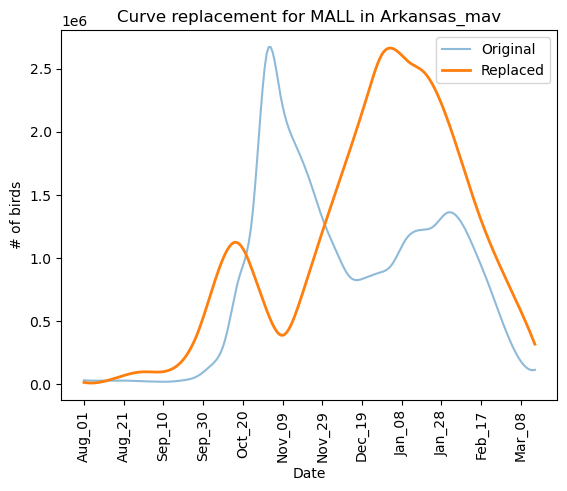

MALL
Louisiana_mav


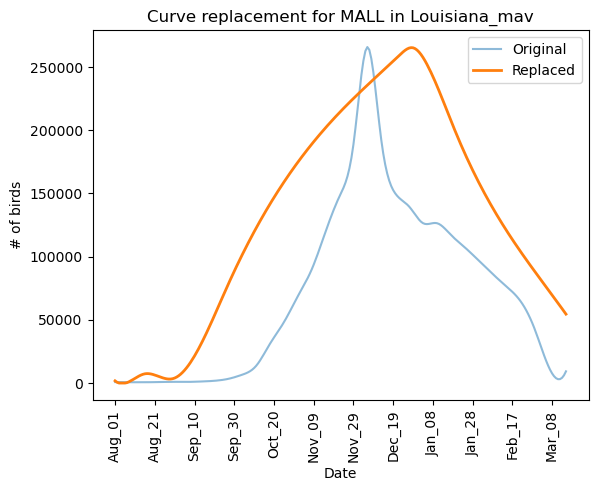

In [24]:
from scipy.interpolate import UnivariateSpline
if customcurves:
    for k, v in customcurvesdict.items():
        sp = k.rsplit("_",1)[1]
        st = k.rsplit("_",1)[0]
        if sp == 'Other':
            continue
        forreplace = np.interp(np.linspace(0, 228, 228), [round(p) for p in np.linspace(0, 228, len(v))], v)
        print(sp)
        print(st)
        spmax = curvetable[(curvetable['species']==sp)&(curvetable['statebcr']==st)]['max'].iloc[0]
        newcurve = forreplace*spmax

        # Interpolate to 229 points
        x_interp = np.linspace(0, 228, 228)
        x_known = [round(p) for p in np.linspace(0, 228, len(v))]
        v_interp = forreplace

        # Smooth using UnivariateSpline
        spline = UnivariateSpline(x_interp, v_interp)
        spline.set_smoothing_factor(0.01)
        v_smooth = spline(x_interp)

        # Scale smoothed values to preserve the original max
        original_max = np.max(v_interp)
        smoothed_max = np.max(v_smooth)
        v_smooth = v_smooth * (original_max / smoothed_max) *spmax
        v_smooth = v_smooth.clip(min=0)
        
        plt.plot(date_labels,list(curvetable[(curvetable['species']==sp)&(curvetable['statebcr']==st)].drop(columns=['species', 'statebcr']).T[:-1].T.iloc[0]), label='Original', alpha=0.5)
        plt.plot(date_labels, v_smooth, label='Replaced', linewidth=2)
        plt.legend()
        plt.title("Curve replacement for {0} in {1}".format(sp, st))
        plt.xticks(np.arange(0, 230, step=20), rotation='vertical')
        plt.xlabel("Date")
        plt.ylabel("# of birds")
        plt.show()
        
        # Replace the values
        curvetable.loc[(curvetable['species'] == sp) & (curvetable['statebcr'] == st), [str(i) for i in range(1, 229)]] = v_smooth        


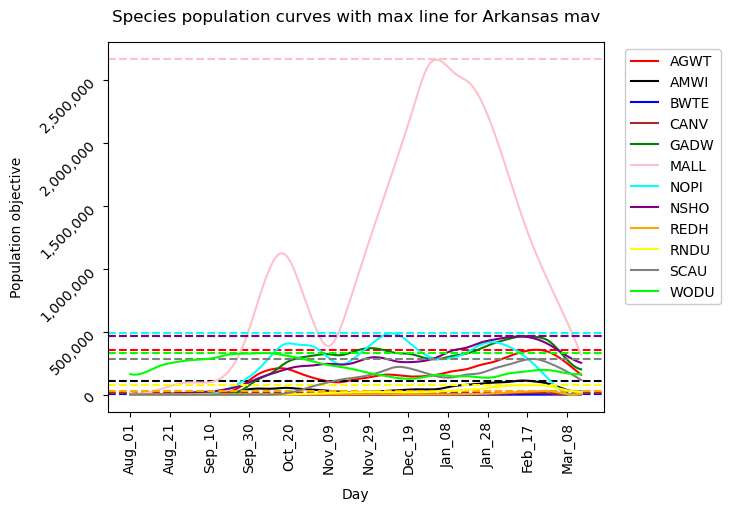

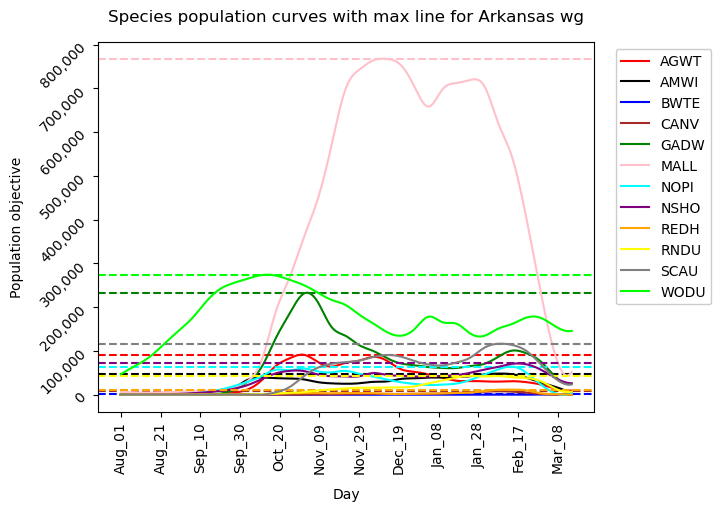

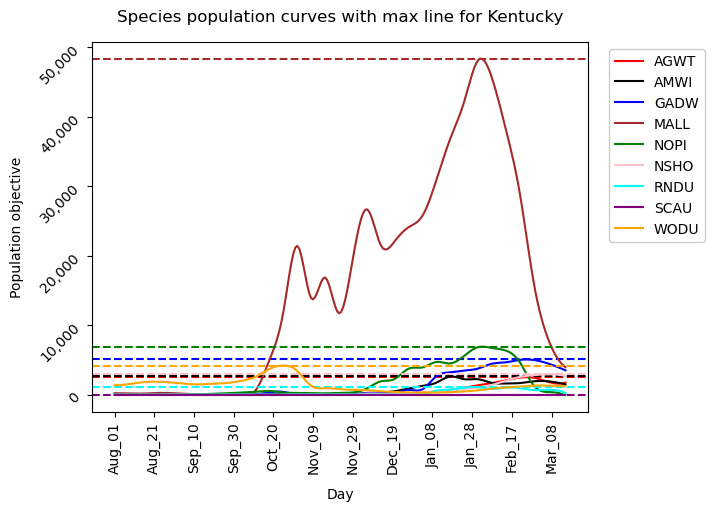

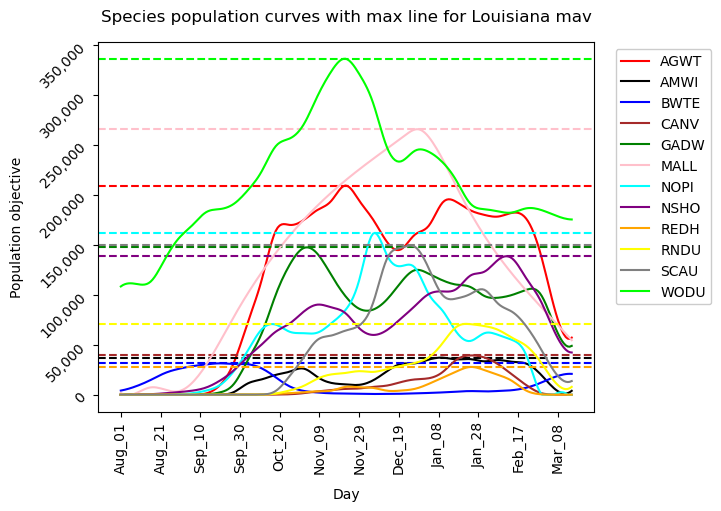

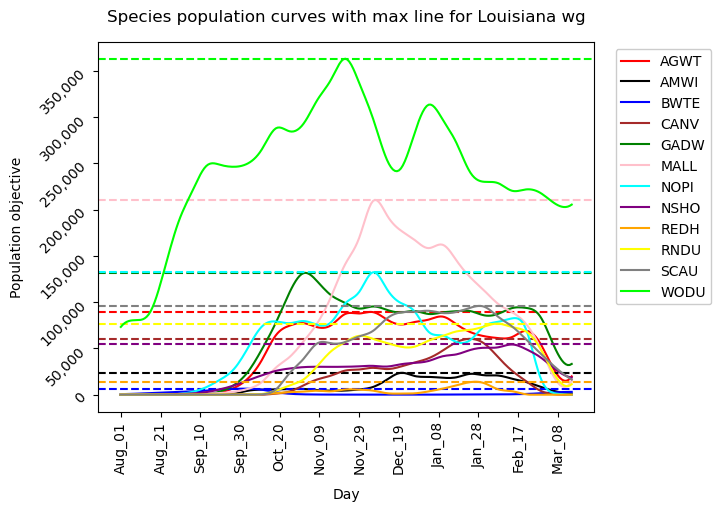

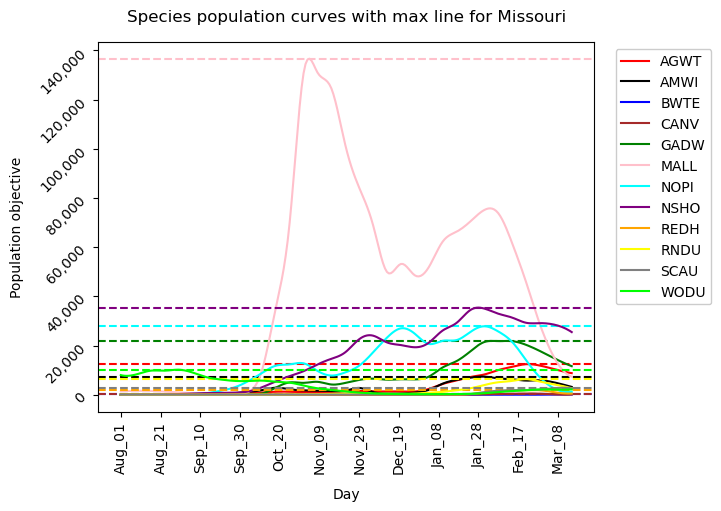

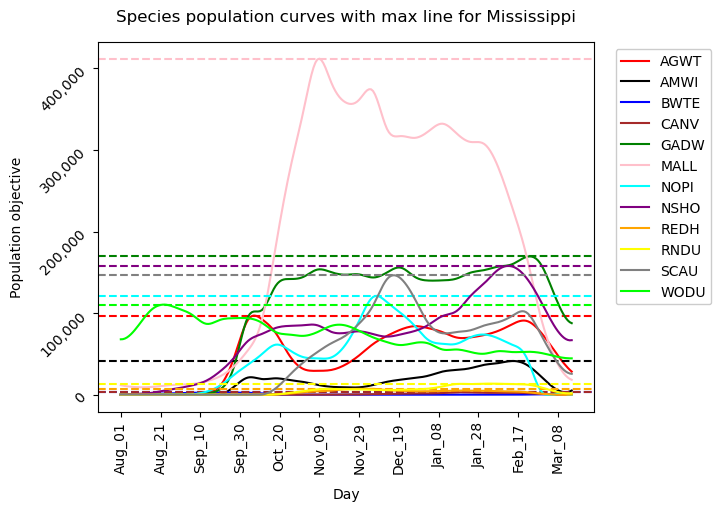

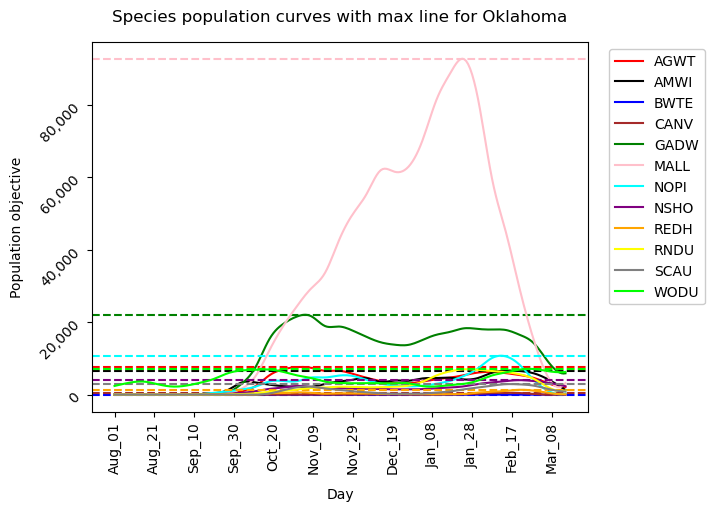

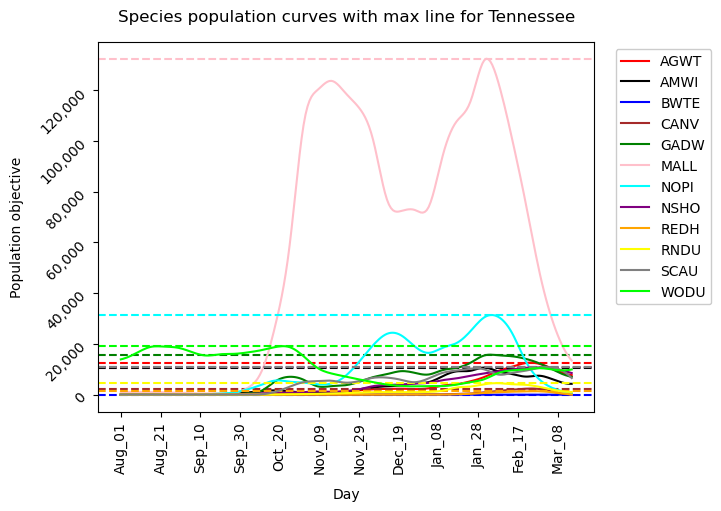

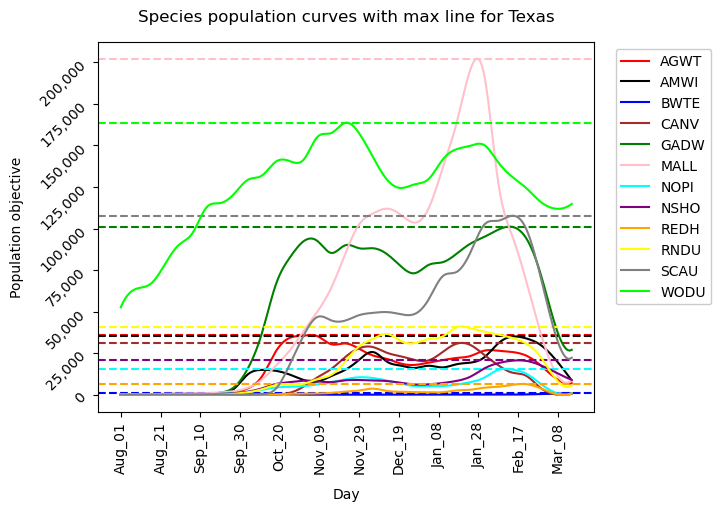

In [25]:
# Plot by species
import math
curvetable = curvetable.replace([np.inf, -np.inf], np.nan).fillna(0)
curveforplot = curvetable.copy()
colors=['red', 'black', 'blue', 'brown', 'green', 'pink', 'cyan', 'purple', 'orange', 'yellow', 'grey', 'lime']
sq = int(math.sqrt(len(curvetable['statebcr'].unique()))+1)
a=0
c=0
d=0
for stbcr in curveforplot['statebcr'].unique():
    i=0
    for sp in curveforplot['species'].unique():
        #print(sp, i)
        ct = curveforplot[curveforplot['statebcr']==stbcr]
        tmp = ct.drop(columns='max').groupby('species').sum().drop(columns='statebcr')
        maxsp = ct[['statebcr', 'max', 'species']].groupby('species').sum().drop(columns='statebcr')
        maxsp = maxsp.reset_index()
        maxsp = maxsp[maxsp['species']==sp]
        tmp = tmp.reset_index()
        tmp = tmp[tmp['species']==sp]
        tmp = tmp.drop(['species'], axis=1).transpose().reset_index()
        try:
            plt.plot(date_labels,tmp[i], color=colors[i], label=sp)
            plt.axhline(y = maxsp['max'][i], color=colors[i], linestyle = '--', label='_') 
        except:
            continue
        i+=1
    plt.legend(framealpha=1, bbox_to_anchor=(1.25, 1),loc='upper right')
    plt.ticklabel_format(style='plain', axis='y')
    plt.xticks(np.arange(0, 230, step=20), rotation='vertical')
    plt.title('Species population curves with max line for {0}'.format(stbcr.replace('_', ' ')), pad=15)
    plt.xlabel('Day', labelpad=10)
    plt.ylabel('Population objective', labelpad=10)
    plt.yticks(rotation=45)
    plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
    plt.savefig('./plots/{0}.png'.format(stbcr), bbox_inches='tight')
    plt.show()

In [26]:
test = curveforplot[(curveforplot['statebcr'] == 'Arkansas_mav') & (curveforplot['species'] == 'AGWT')]
test = test.drop(columns=['statebcr', 'species', 'max'])
test.sum(axis=1)

0   34,090,771.44
dtype: float64

In [27]:
curvetable = curvetable.groupby(['statebcr']).sum().reset_index()#.drop(['Unnamed: 0'], axis=1)

In [28]:
curvetable = curvetable.drop(columns='species')
#curvetable[(curvetable['statebcr']=='Arkansas_mav')].drop(columns=['statebcr']).transpose().max()

In [29]:
curvetable = curvetable.replace([np.inf, -np.inf], np.nan).fillna(0)
curvetable = curvetable.drop(columns=['max'], axis=1)
curvetable.head()

statebcr          1          2          3          4          5  \
0   Arkansas_mav 179,279.81 174,434.76 172,148.51 172,223.92 174,463.91   
1    Arkansas_wg  53,619.60  56,417.81  59,130.01  61,736.22  64,259.08   
2       Kentucky   1,563.26   1,564.08   1,572.12   1,586.52   1,606.59   
3  Louisiana_mav 114,098.17 114,677.92 115,487.97 116,604.23 117,478.94   
4   Louisiana_wg  74,498.21  76,910.94  78,744.27  80,063.81  80,960.59   

           6          7          8          9  ...          219          220  \
0 178,671.42 184,649.35 192,200.63 201,128.19  ... 2,057,461.57 1,950,778.08   
1  66,721.20  69,145.22  71,553.76  73,969.44  ...   440,945.53   405,645.50   
2   1,631.60   1,660.87   1,693.67   1,729.31  ...    21,883.85    20,928.55   
3 118,163.30 119,014.93 120,164.16 121,412.59  ...   539,945.51   516,058.66   
4  81,532.98  81,868.93  82,058.43  82,192.13  ...   399,520.10   378,333.06   

           221          222          223          224          225  \
0 1,847,501.58 1,748,555.45 1,657,500.99 1,570,341.93 1,487,523.72   
1   374,034.44   346,585.69   324,069.78   306,624.77   294,344.07   
2    20,027.62    19,175.14    18,365.13    17,591.67    16,848.80   
3   494,061.20   474,255.35   456,943.31   442,427.31   431,009.55   
4   359,484.00   343,334.07   330,244.43   320,576.25   314,690.89   

           226          227          228  
0 1,414,542.11 1,351,098.45 1,297,525.41  
1   288,020.53   288,911.60   297,383.80  
2    16,130.57    15,431.04    14,881.49  
3   422,992.24   421,068.00   424,086.31  
4   312,948.89   316,073.85   324,233.57  

[5 rows x 229 columns]

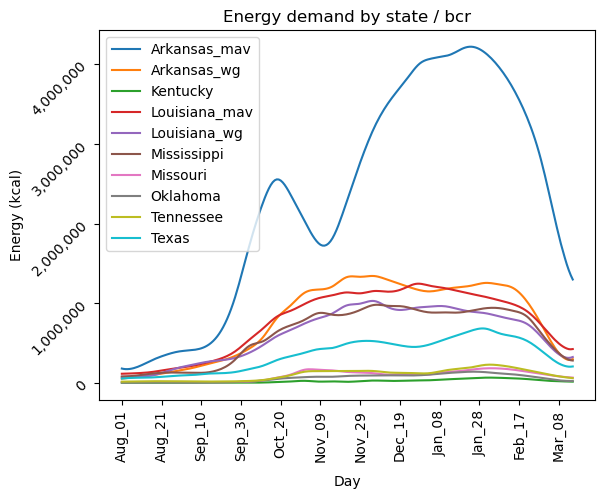

In [30]:
# sum energy demand by statebcr, removing species.
#display(curvetable.head())
i=0
aucsp = {}
for st in curvetable['statebcr'].unique():
    query = pd.DataFrame(curvetable[curvetable['statebcr']==st]).drop('statebcr',axis=1).transpose().reset_index()
    plt.plot(date_labels, query[i])
    aucsp[st]=(np.trapz(query[i].apply(int), query['index'].apply(int)))
    i+=1
plt.legend(curvetable['statebcr'].unique())    
plt.title('Energy demand by state / bcr')
plt.xticks(np.arange(0, 230, step=20), rotation='vertical')
plt.xlabel('Day', labelpad=10)
plt.ylabel('Energy (kcal)')
plt.yticks(rotation=45)
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.savefig('./plots/{0}.png'.format('demandbystatebcr'), bbox_inches='tight')

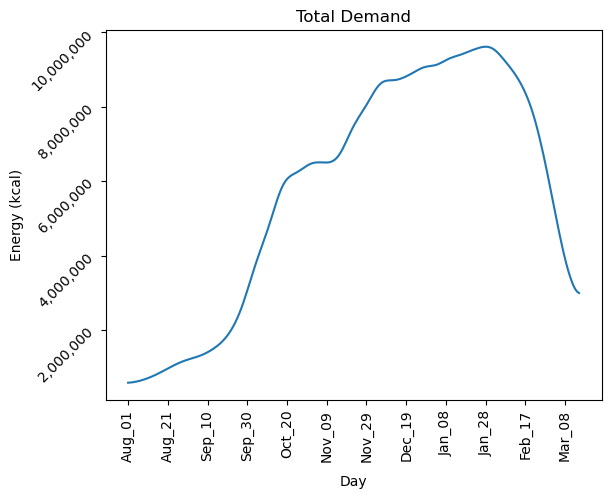

In [31]:
totaldemand = curvetable.sum().reset_index().drop([0])
plt.plot(date_labels, totaldemand[0])
plt.xticks(np.arange(0, 230, step=20), rotation='vertical')
plt.title('Total Demand')
plt.xlabel('Day', labelpad=10)
plt.ylabel('Energy (kcal)')
plt.yticks(rotation=45)
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.savefig('./plots/{0}.png'.format('TotalDemand'), bbox_inches='tight')

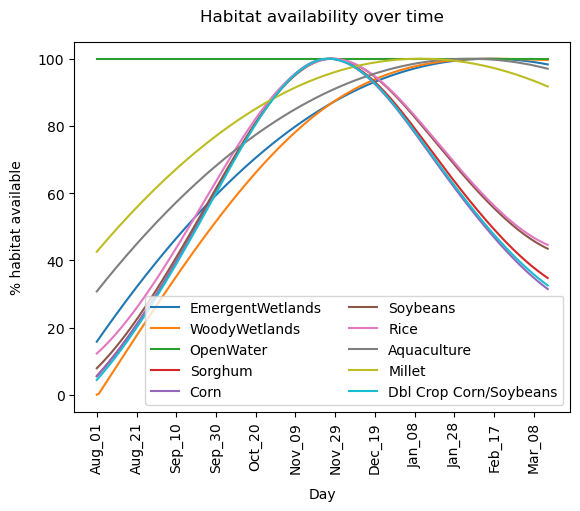

In [32]:
# Calculate habitat curves
habitatcurvedata = {}
for sp in cropcurvedata.keys():
    habitatcurvedata[sp] = np.interp(np.linspace(1, 228, 228), [round(p) for p in np.linspace(1, 228, len(cropcurvedata[sp]))], cropcurvedata[sp])
    if smoothcrops:
        # Interpolate to 229 points
        x_interp = np.linspace(1, 228, 228)
        x_known = [round(p) for p in np.linspace(1, 228, len(cropcurvedata[sp]))]
        v_interp = habitatcurvedata[sp]

        # Smooth using UnivariateSpline
        spline = UnivariateSpline(x_interp, v_interp)
        spline.set_smoothing_factor(1000)
        v_smooth = spline(x_interp)

        # Scale smoothed values to preserve the original max
        original_max = np.max(v_interp)
        smoothed_max = np.max(v_smooth)

        v_smooth = v_smooth * (100.0 / np.max(v_smooth))
        v_smooth = v_smooth.clip(min=0)
        habitatcurvedata[sp] = v_smooth
  
habitatcurve = pd.DataFrame.from_dict(habitatcurvedata).transpose().reset_index().rename(columns={'index':'CLASS'})
habitatcurve.columns = ['CLASS'] + list(range(1, 229))

for sp in cropcurvedata.keys():
    model = habitatcurvedata[sp]
    plt.plot(date_labels, model, label=sp)
plt.legend(ncol=2)#loc='upper right',bbox_to_anchor=(1.5, 0))
plt.title('Habitat availability over time', pad=15)
plt.xlabel('Day', labelpad=10)
plt.xticks(np.arange(0, 230, step=20), rotation='vertical')
plt.ylabel('% habitat available', labelpad=10)

plt.savefig('./plots/{0}.png'.format('Habitalavailability'), bbox_inches='tight')

In [33]:
inenergy = inenergy.dropna(subset=['statebcr'])
display(inenergy.head())
display(inenergy['statebcr'].unique())

FIPS      NAME             CLASS  ValueLo  ValueHi     acres  \
0  05001  Arkansas       Aquaculture        3     1954      0.44   
1  05001  Arkansas              Corn     1130    22530  3,706.74   
2  05001  Arkansas  EmergentWetlands      247     1622    112.75   
3  05001  Arkansas            Millet        0      937      2.89   
4  05001  Arkansas         OpenWater        3        3 15,418.21   

       statebcr       kcalLo  decomp  
0  Arkansas_mav         1.33    0.00  
1  Arkansas_mav 4,188,618.74    1.57  
2  Arkansas_mav    27,850.32    0.18  
3  Arkansas_mav         0.00    0.64  
4  Arkansas_mav    46,254.64    0.00

array(['Arkansas_mav', 'Arkansas_wg', 'Illinois', 'Kentucky',
       'Louisiana_wg', 'Louisiana_mav', 'Mississippi', 'Missouri',
       'Oklahoma', 'Tennessee', 'Texas'], dtype=object)

In [34]:
# Energy under the curve
tmpx = totaldemand['index'].apply(int)
tmpy = totaldemand[0].apply(int)
totaldemandarea = np.trapz(tmpy,tmpx)
print('Demand AuC:',f'{totaldemandarea:,.0f}')
print('Demand sum:', f'{tmpy.sum():,.0f}')
print('Energy supply sum:',f'{round(inenergy.ValueLo * inenergy.acres).sum():,.0f}')
print('############')
print('Demand')
print(pd.DataFrame({'statebcr': list(aucsp.keys()), 'demand': list(aucsp.values())}))
blah = inenergy.groupby(['statebcr', 'ValueLo'],as_index=False).sum()[['statebcr', 'ValueLo', 'acres']]
blah['energy supply'] = blah['ValueLo'] * blah['acres']
print('Energy supply')
print(blah.groupby('statebcr', as_index=False).sum()[['statebcr', 'energy supply']])

Demand AuC: 1,316,400,268
Demand sum: 1,318,188,320
Energy supply sum: 2,305,991,168
############
Demand
        statebcr         demand
0   Arkansas_mav 528,719,018.00
1    Arkansas_wg 184,607,696.00
2       Kentucky   5,109,545.00
3  Louisiana_mav 176,566,693.00
4   Louisiana_wg 141,283,689.50
5    Mississippi 141,052,788.50
6       Missouri  20,716,559.00
7       Oklahoma  14,216,161.50
8      Tennessee  23,369,167.50
9          Texas  80,757,922.00
Energy supply
         statebcr    energy supply
0    Arkansas_mav 1,018,753,360.25
1     Arkansas_wg    84,717,085.52
2        Illinois     5,246,850.20
3        Kentucky    12,261,805.14
4   Louisiana_mav   384,020,103.54
5    Louisiana_wg    87,365,618.57
6     Mississippi   336,246,460.28
7        Missouri   268,664,705.22
8        Oklahoma    14,177,636.51
9       Tennessee    34,496,161.77
10          Texas    60,041,394.44


In [35]:
################ Start daily energy calculation ################

In [36]:
# testing daily iteration and aggregation
trackenergy = pd.DataFrame() # create empty dataframe to hold output by day
energylayer = inenergy.copy().fillna(0)
energylayer['unique'] = energylayer.index
energylayer['vegenergyprevLo'] = 0
energylayer['vegenergyprevHi'] = 0
energylayer['leftoverLo'] = 0
energylayer['leftoverHi'] = 0
trackhideficit = pd.DataFrame()
tracklodeficit = pd.DataFrame()
pd.set_option('display.max_columns', None)
for i in range(1,229): #1 to 228
    energylayer['day'] = i
    # Get habitat availability based on habitat curve and calculate available acres
    hab = habitatcurve[['CLASS', i]] # select habitat availability curve for day by class
    
    energylayer = energylayer.merge(hab, on='CLASS', how='left') # merge habitat curve to the energy layer
    energylayer['habpct'] = energylayer[i]
    energylayer = energylayer.drop(i, axis=1) # Drop habitat percentage day column
    energylayer['availacres']= energylayer['acres'] * energylayer['habpct']*.01# calculate available acres which is acres of the energy polygon * habitat type availability for that day.    
    # Calculate energy supply
    energylayer['vegenergyLo'] = energylayer['availacres'] * energylayer['ValueLo']
    energylayer['vegenergyHi'] = energylayer['availacres'] * energylayer['ValueHi']
    energylayer['diffLo'] = (energylayer['vegenergyLo'] - energylayer['vegenergyprevLo']).clip(lower=0) # Energy supply includes the leftover energy from the day before plus the difference between todays supply energy and yesterdays.
    #energylayer['diffLo'] = energylayer['diffLo'].clip(lower=0)
    energylayer['diffHi'] = (energylayer['vegenergyHi'] - energylayer['vegenergyprevHi']).clip(lower=0)
    energylayer['vegenergyprevLo'] = energylayer['vegenergyLo']
    energylayer['vegenergyprevHi'] = energylayer['vegenergyHi']
    # Add supply from previous day
    energylayer['supplyLo'] = (energylayer['diffLo'] + energylayer['leftoverLo']).clip(lower=0)
    energylayer['supplyLoNeg'] = energylayer['diffLo'] + energylayer['leftoverLo']
    energylayer['supplyHi'] = (energylayer['diffHi'] + energylayer['leftoverHi']).clip(lower=0)    
    energylayer['supplyHiNeg'] = energylayer['diffHi'] + energylayer['leftoverHi']    
    
    # Proportion demand based on energy supply at the record level.
    energylayerbystatebcr = energylayer[['statebcr','supplyLo', 'supplyHi']].groupby(['statebcr']).sum().rename(columns={'supplyLo':'supplyLoMax', 'supplyHi':'supplyHiMax'})
    for a in ('supplyLoMax', 'supplyHiMax'):
        if a in energylayer.columns:
            energylayer = energylayer.drop(a, axis=1)

    energylayer = energylayer.merge(energylayerbystatebcr, on='statebcr', how='left')
    energylayer['pctdemand'] = energylayer['supplyHi']/energylayer['supplyHiMax']
    energylayer.loc[np.isnan(energylayer['pctdemand']),['pctdemand']] = 0
    popcurve = curvetable[['statebcr', str(i)]] # select demand for the day based on curve.
    
    energylayer = energylayer.merge(popcurve, on='statebcr', how='left') # merge demand for that day based on statebcr
    energylayer['demand'] = energylayer['pctdemand']*energylayer[str(i)]

    # Calculate leftover energy
    energylayer['leftoverLo'] = energylayer['supplyLo'] - energylayer['demand']
    energylayer['leftoverHi'] = energylayer['supplyHi'] - energylayer['demand']
    
    # Decomp  *** need to only factor in decomp is leftover is positive.
    energylayer['leftoverLo'] = energylayer['leftoverLo'] * ((100-energylayer['decomp'])*.01)
    energylayer['leftoverHi'] = energylayer['leftoverHi'] * ((100-energylayer['decomp'])*.01)    
    #for a in ('supplyLoMax', 'supplyHiMax', str(i)):
    #    if a in energylayer.columns:
    #        energylayer = energylayer.drop(a, axis=1)  
    trackenergy = pd.concat([trackenergy, energylayer])
    tracklodeficit = pd.concat([tracklodeficit,energylayer[['day','statebcr','leftoverLo']].groupby(['day','statebcr']).sum().reset_index()])
    trackhideficit = pd.concat([trackhideficit,energylayer[['day','statebcr','leftoverHi']].groupby(['day','statebcr']).sum().reset_index()])


In [55]:
sample = trackenergy[trackenergy['day']==228]
printme = sample[['statebcr','CLASS', 'supplyLo', 'demand', 'leftoverLo']].groupby(['statebcr','CLASS']).sum()
print(printme.sum())
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(printme)
printme = printme.reset_index()


supplyLo     215,204,284.96
demand         2,992,604.00
leftoverLo   211,577,486.96
dtype: float64
                                          supplyLo       demand    leftoverLo
statebcr      CLASS                                                          
Arkansas_mav  Aquaculture                     0.00       249.36       -249.36
              Corn                            0.00    14,542.99    -14,314.67
              EmergentWetlands          768,202.31     3,860.83    762,965.67
              Millet                          0.00         5.89         -5.85
              OpenWater                 531,323.22     3,950.67    527,372.55
              Rice                            0.00 1,246,145.17 -1,243,490.88
              Sorghum                   129,055.89       165.64    128,475.22
              Soybeans               14,751,807.12    24,714.53 14,447,277.83
              WoodyWetlands           5,854,546.04     3,890.33  5,850,439.23
Arkansas_wg   Aquaculture                  

In [37]:
energylayer.head()
#popcurve = curvetable[['statebcr', str(1)]] # select demand for the day based on curve.
#trackenergy = trackenergy[trackenergy['statebcr'] != 0]
#display(trackenergy[['day', 'statebcr','demandLo']].loc[trackenergy['day']==1].groupby(['day', 'statebcr']).sum())
#display(popcurve)
#display(trackenergy[trackenergy['day']==1].groupby(['statebcr']).sum())
#display(trackenergy[['day', 'supplyLo', 'statebcr']].groupby(['day', 'statebcr']).sum())

FIPS      NAME             CLASS  ValueLo  ValueHi     acres  \
0  05001  Arkansas       Aquaculture        3     1954      0.44   
1  05001  Arkansas              Corn     1130    22530  3,706.74   
2  05001  Arkansas  EmergentWetlands      247     1622    112.75   
3  05001  Arkansas            Millet        0      937      2.89   
4  05001  Arkansas         OpenWater        3        3 15,418.21   

       statebcr       kcalLo  decomp  unique  vegenergyprevLo  \
0  Arkansas_mav         1.33    0.00       0             1.29   
1  Arkansas_mav 4,188,618.74    1.57       1     1,317,509.14   
2  Arkansas_mav    27,850.32    0.18       2        27,375.91   
3  Arkansas_mav         0.00    0.64       3             0.00   
4  Arkansas_mav    46,254.64    0.00       4        46,254.64   

   vegenergyprevHi  leftoverLo   leftoverHi  day  habpct  availacres  \
0           843.22       -0.26       785.61  228   97.02        0.43   
1    26,268,567.17   -1,716.59 5,092,174.69  228   31.45    1,165.94   
2       179,772.19    8,157.08   122,225.81  228   98.30      110.83   
3         2,485.02       -0.24       718.42  228   91.73        2.65   
4        46,254.64   41,368.73    41,368.73  228  100.00   15,418.21   

   vegenergyLo   vegenergyHi  diffLo  diffHi  supplyLo  supplyLoNeg  \
0         1.29        843.22    0.00    0.00      0.00        -0.28   
1 1,317,509.14 26,268,567.17    0.00    0.00      0.00    -1,811.27   
2    27,375.91    179,772.19    0.00    0.00  8,213.06     8,213.06   
3         0.00      2,485.02    0.00    0.00      0.00        -0.25   
4    46,254.64     46,254.64    0.00    0.00 41,382.68    41,382.68   

      supplyHi  supplyHiNeg  pctdemand          1   demand          2  \
0       785.88       785.88       0.00 179,279.81     0.26 174,434.76   
1 5,175,141.00 5,175,141.00       0.00 179,279.81 1,743.98 174,434.76   
2   122,487.49   122,487.49       0.00 179,279.81    41.28 174,434.76   
3       723.29       723.29       0.00 179,279.81     0.24 174,434.76   
4    41,382.68    41,382.68       0.00 179,279.81    13.95 174,434.76   

           3          4          5          6          7          8  \
0 172,148.51 172,223.92 174,463.91 178,671.42 184,649.35 192,200.63   
1 172,148.51 172,223.92 174,463.91 178,671.42 184,649.35 192,200.63   
2 172,148.51 172,223.92 174,463.91 178,671.42 184,649.35 192,200.63   
3 172,148.51 172,223.92 174,463.91 178,671.42 184,649.35 192,200.63   
4 172,148.51 172,223.92 174,463.91 178,671.42 184,649.35 192,200.63   

           9         10         11         12         13         14  \
0 201,128.19 211,224.99 222,243.74 233,927.18 246,018.03 258,259.04   
1 201,128.19 211,224.99 222,243.74 233,927.18 246,018.03 258,259.04   
2 201,128.19 211,224.99 222,243.74 233,927.18 246,018.03 258,259.04   
3 201,128.19 211,224.99 222,243.74 233,927.18 246,018.03 258,259.04   
4 201,128.19 211,224.99 222,243.74 233,927.18 246,018.03 258,259.04   

          15         16         17         18         19         20  \
0 270,392.94 282,162.47 293,363.48 303,985.10 314,071.26 323,665.91   
1 270,392.94 282,162.47 293,363.48 303,985.10 314,071.26 323,665.91   
2 270,392.94 282,162.47 293,363.48 303,985.10 314,071.26 323,665.91   
3 270,392.94 282,162.47 293,363.48 303,985.10 314,071.26 323,665.91   
4 270,392.94 282,162.47 293,363.48 303,985.10 314,071.26 323,665.91   

          21         22         23         24         25         26  \
0 332,812.99 341,556.43 349,940.17 357,988.07 365,634.16 372,792.54   
1 332,812.99 341,556.43 349,940.17 357,988.07 365,634.16 372,792.54   
2 332,812.99 341,556.43 349,940.17 357,988.07 365,634.16 372,792.54   
3 332,812.99 341,556.43 349,940.17 357,988.07 365,634.16 372,792.54   
4 332,812.99 341,556.43 349,940.17 357,988.07 365,634.16 372,792.54   

          27         28         29         30         31         32  \
0 379,377.30 385,302.53 390,482.34 394,830.80 398,318.49 401,117.25   
1 379,377.30 385,302.53 390,482.34 394,830.80 398,318.4

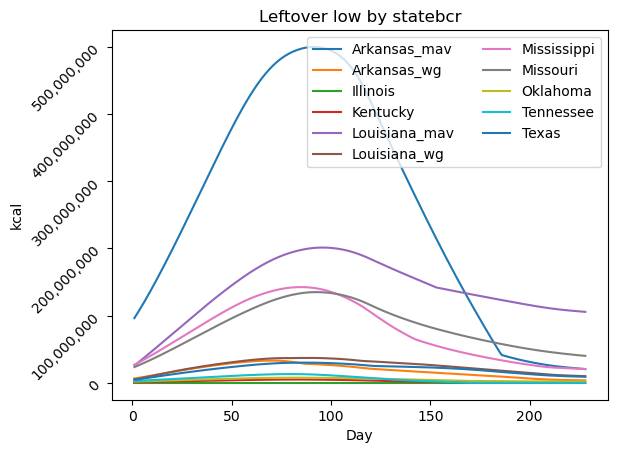

In [40]:
'''
plt.plot(list(range(1,229)),trackhideficit)
plt.plot(list(range(1,229)),tracklodeficit)
plt.title('Energy deficit over time')
plt.legend(['High', 'Low'])
'''

tracklodeficit = tracklodeficit[tracklodeficit['statebcr'] != 0]
#tracklodeficit = tracklodeficit[tracklodeficit['statebcr'] != 'Kentucky']
for st in tracklodeficit['statebcr'].unique():
    query = tracklodeficit[tracklodeficit['statebcr']==st].drop(['statebcr'],axis=1)
    plt.plot(query[['day']], query[['leftoverLo']])
plt.legend(tracklodeficit['statebcr'].unique(), ncol=2)#,bbox_to_anchor=(1.35, 1),loc='upper right')
plt.ticklabel_format(style='plain')
plt.title('Leftover low by statebcr')
plt.xlabel('Day')
plt.ylabel('kcal')
plt.yticks(rotation=45)
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.savefig('./plots/{0}.png'.format('LeftoverLowbyState'), bbox_inches='tight')

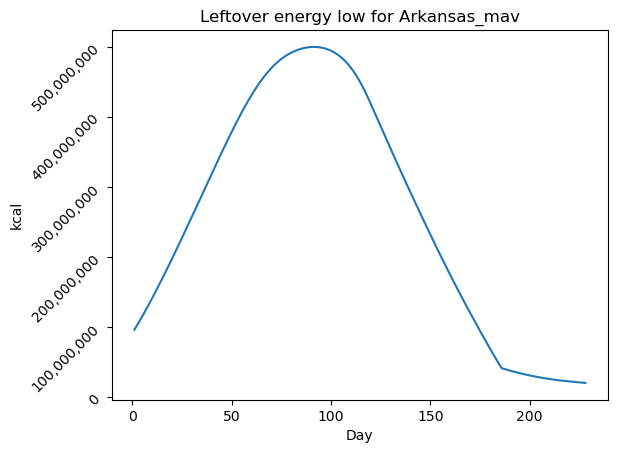

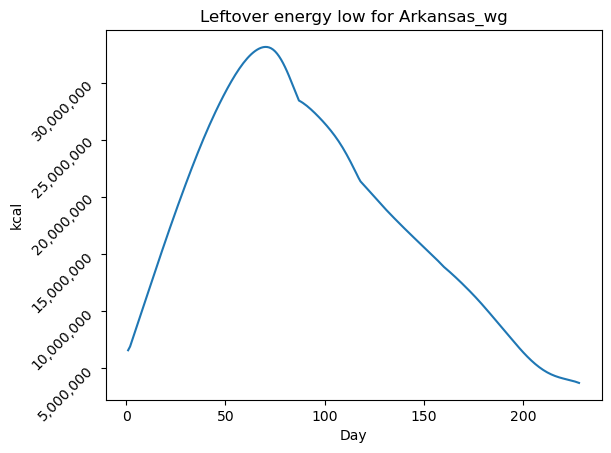

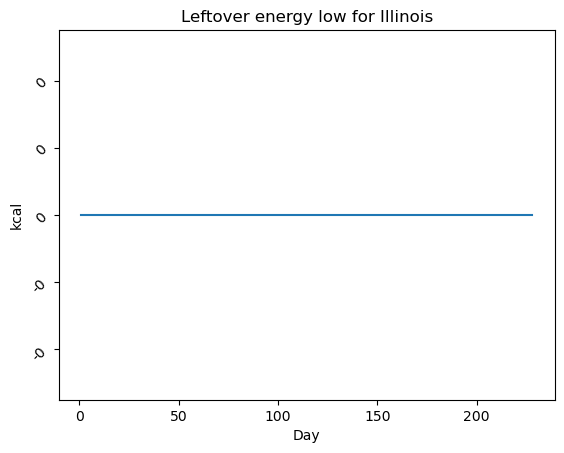

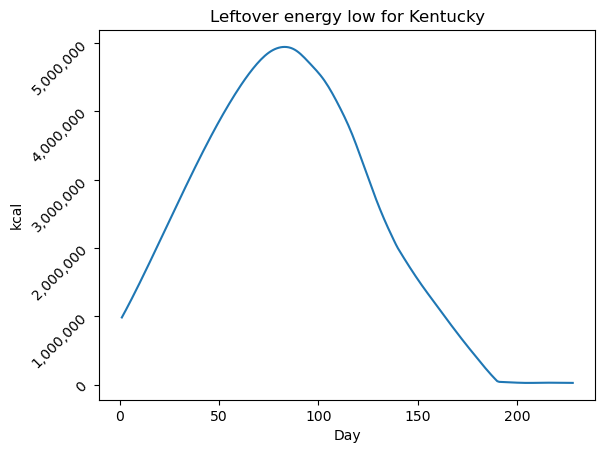

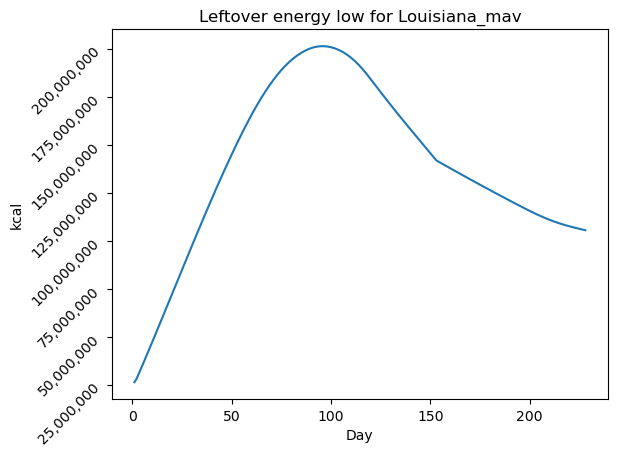

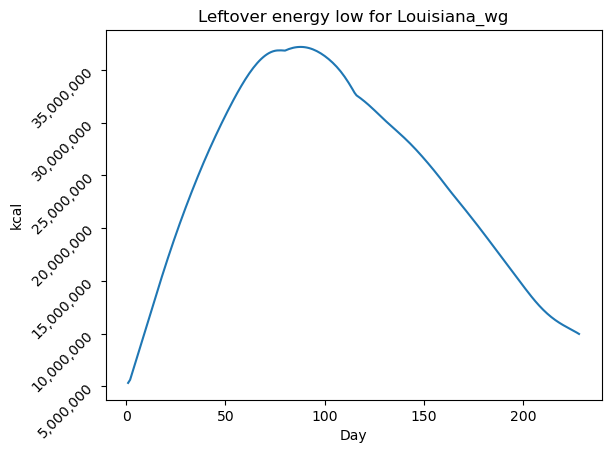

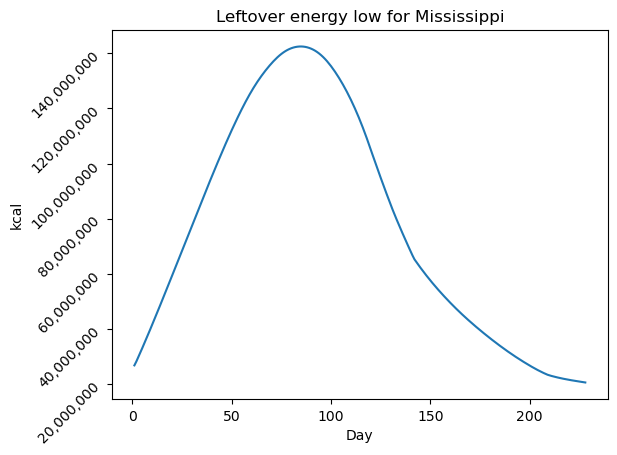

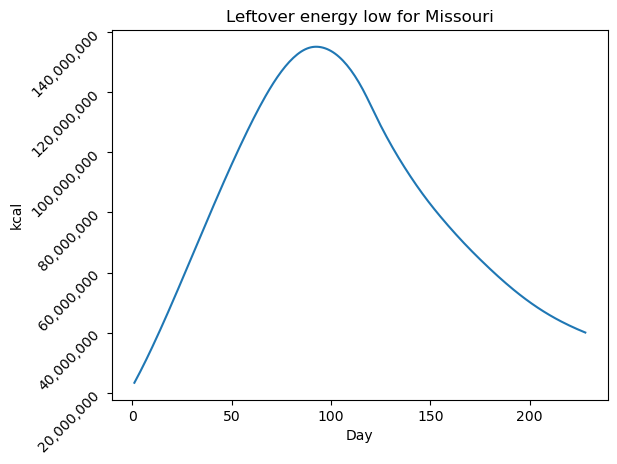

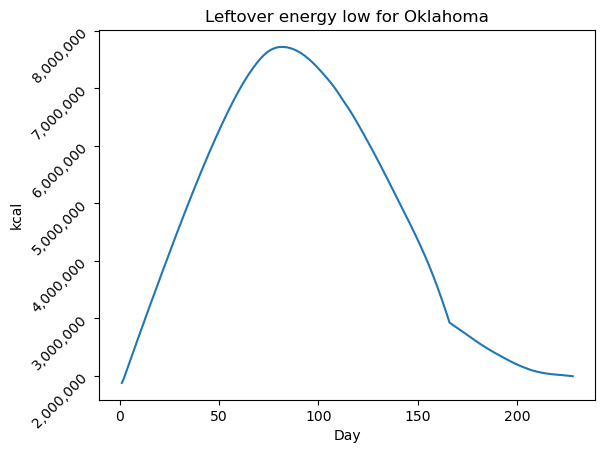

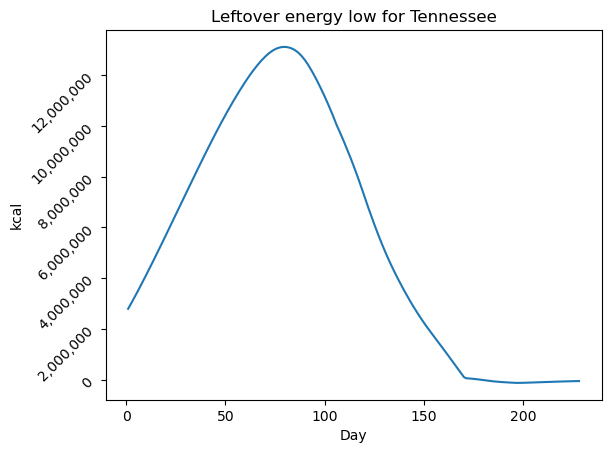

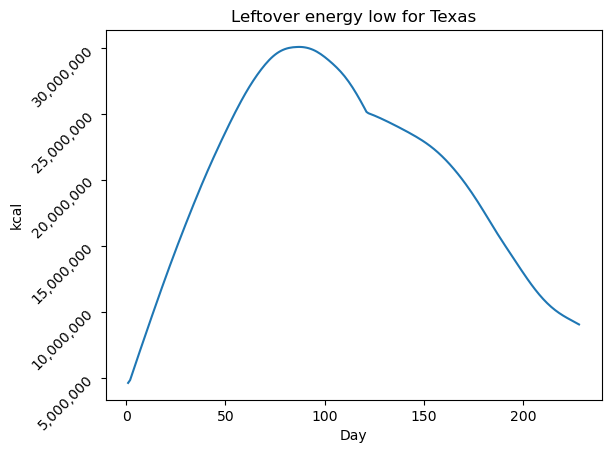

In [41]:
for stbcr in tracklodeficit['statebcr'].unique():
    query = tracklodeficit[tracklodeficit['statebcr']==stbcr].drop(['statebcr'],axis=1)
    plt.plot(query[['day']], query[['leftoverLo']])
    plt.ticklabel_format(style='plain')
    plt.title('Leftover energy low for {0}'.format(stbcr))
    plt.xlabel('Day')
    plt.ylabel('kcal')
    plt.yticks(rotation=45)
    plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
    plt.savefig('./plots/leftoverenergy_{0}.png'.format(stbcr), bbox_inches='tight')
    plt.show()

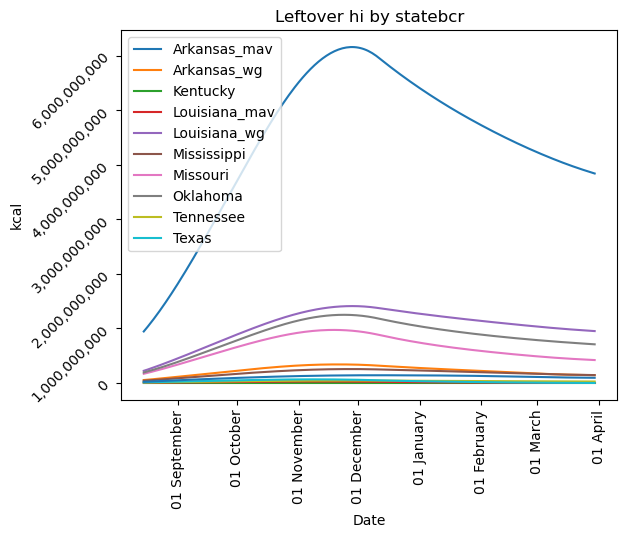

In [42]:
from datetime import datetime, timedelta
import matplotlib.dates as mdates
i=0
start_date = datetime(2024, 8, 15)  # Starting date
days = list(range(1, 229))  # Days 1 to 200
dates = [start_date + timedelta(days=day - 1) for day in days]

for st in trackhideficit['statebcr'].unique():
    query = trackhideficit[trackhideficit['statebcr']==st].drop(['statebcr'],axis=1)
    plt.plot(dates, query['leftoverHi'])
    i+=1
plt.legend(curvetable['statebcr'].unique())
#plt.ticklabel_format(style='plain')
plt.title('Leftover hi by statebcr')
plt.ylabel('kcal')
plt.yticks(rotation=45)
plt.xticks(rotation=90)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d %B'))  # Format: "08/15"
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Major ticks at the start of each month
plt.xlabel('Date')
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.savefig('./plots/{0}.png'.format('LeftoverHighbyState'), bbox_inches='tight')

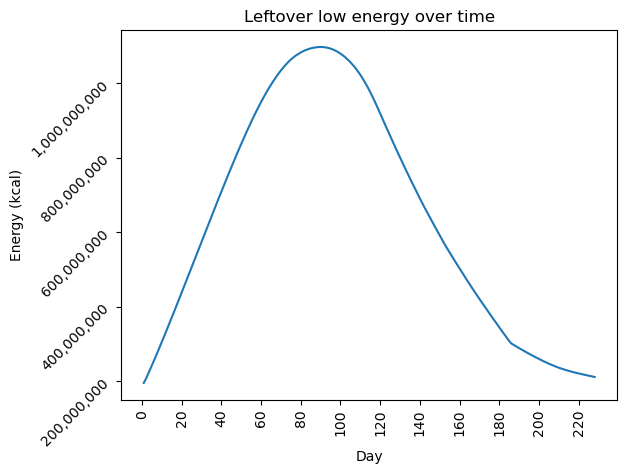

In [43]:
#plt.plot(list(range(1,229)),trackenergy[['day','leftoverHi']].groupby(['day']).sum().reset_index()['leftoverHi'])
plt.plot(list(range(1,229)),trackenergy[['day','leftoverLo']].groupby(['day']).sum().reset_index()['leftoverLo'])
plt.title('Leftover low energy over time')
#plt.legend(['Low energy value'])
plt.xticks(np.arange(0, 230, step=20), rotation='vertical')
plt.xlabel('Day', labelpad=10)
plt.ylabel('Energy (kcal)')
plt.yticks(rotation=45)
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.savefig('./plots/{0}.png'.format('LeftoverLowEnergyOverTime'), bbox_inches='tight')

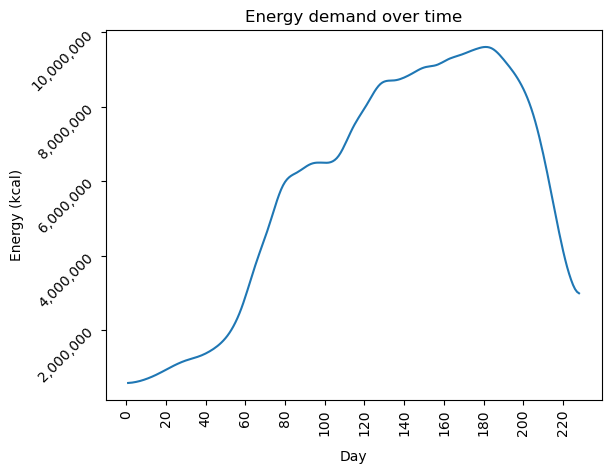

In [44]:
plt.plot(list(range(1,229)),trackenergy[['day','demand']].groupby(['day']).sum().reset_index()['demand'])
plt.title('Energy demand over time')
plt.xticks(np.arange(0, 230, step=20), rotation='vertical')
plt.xlabel('Day', labelpad=10)
plt.ylabel('Energy (kcal)')
plt.yticks(rotation=45)
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.savefig('./plots/{0}.png'.format('DemandOverTime'), bbox_inches='tight')

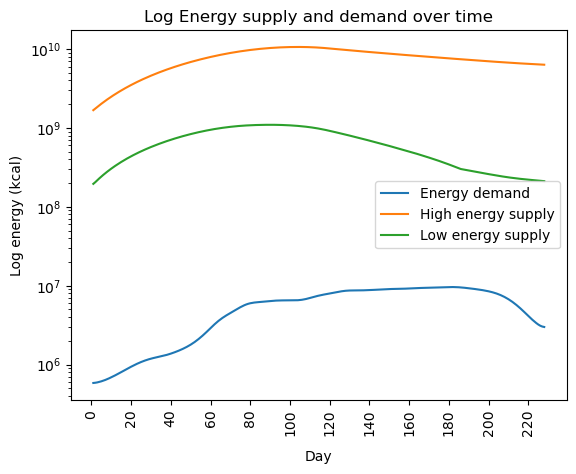

In [45]:
plt.plot(list(range(1,229)),trackenergy[['day','demand']].groupby(['day']).sum().reset_index()['demand'])
plt.plot(list(range(1,229)),trackenergy[['day','leftoverHi']].groupby(['day']).sum().reset_index()['leftoverHi'])
plt.plot(list(range(1,229)),trackenergy[['day','leftoverLo']].groupby(['day']).sum().reset_index()['leftoverLo'])
plt.legend(['Energy demand', 'High energy supply', 'Low energy supply'])
plt.title('Log Energy supply and demand over time')
plt.yscale('log')
plt.xticks(np.arange(0, 230, step=20), rotation='vertical')
plt.xlabel('Day', labelpad=10)
plt.ylabel('Log energy (kcal)')
#plt.yticks(rotation=45)
#plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.savefig('./plots/{0}.png'.format('LogEnergyDemandAndSupply'), bbox_inches='tight')

In [46]:
trackenergy.head()

FIPS      NAME             CLASS  ValueLo  ValueHi     acres  \
0  05001  Arkansas       Aquaculture        3     1954      0.44   
1  05001  Arkansas              Corn     1130    22530  3,706.74   
2  05001  Arkansas  EmergentWetlands      247     1622    112.75   
3  05001  Arkansas            Millet        0      937      2.89   
4  05001  Arkansas         OpenWater        3        3 15,418.21   

       statebcr       kcalLo  decomp  unique  vegenergyprevLo  \
0  Arkansas_mav         1.33    0.00       0             0.41   
1  Arkansas_mav 4,188,618.74    1.57       1       229,852.51   
2  Arkansas_mav    27,850.32    0.18       2         4,392.51   
3  Arkansas_mav         0.00    0.64       3             0.00   
4  Arkansas_mav    46,254.64    0.00       4        46,254.64   

   vegenergyprevHi  leftoverLo   leftoverHi  day  habpct  availacres  \
0           267.18        0.36       267.13    1   30.74        0.14   
1     4,582,811.50  225,392.95 4,510,010.49    1    5.49      203.41   
2        28,844.76    4,379.18    28,787.41    1   15.77       17.78   
3         1,152.95       -0.22     1,145.35    1   42.56        1.23   
4        46,254.64   46,245.92    46,245.92    1  100.00   15,418.21   

   vegenergyLo  vegenergyHi     diffLo       diffHi   supplyLo  supplyLoNeg  \
0         0.41       267.18       0.41       267.18       0.41         0.41   
1   229,852.51 4,582,811.50 229,852.51 4,582,811.50 229,852.51   229,852.51   
2     4,392.51    28,844.76   4,392.51    28,844.76   4,392.51     4,392.51   
3         0.00     1,152.95       0.00     1,152.95       0.00         0.00   
4    46,254.64    46,254.64  46,254.64    46,254.64  46,254.64    46,254.64   

      supplyHi  supplyHiNeg   supplyLoMax    supplyHiMax  pctdemand  \
0       267.18       267.18 97,586,771.01 950,446,819.17       0.00   
1 4,582,811.50 4,582,811.50 97,586,771.01 950,446,819.17       0.00   
2    28,844.76    28,844.76 97,586,771.01 950,446,819.17       0.00   
3     1,152.95     1,152.95 97,586,771.01 950,446,819.17       0.00   
4    46,254.64    46,254.64 97,586,771.01 950,446,819.17       0.00   

           1  demand   2   3   4   5   6   7   8   9  10  11  12  13  14  15  \
0 179,279.81    0.05 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN   
1 179,279.81  864.44 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN   
2 179,279.81    5.44 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN   
3 179,279.81    0.22 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN   
4 179,279.81    8.72 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN   

   16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  \
0 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN   
1 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN   
2 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN   
3 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN   
4 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN   

   35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  \
0 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN   
1 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN   
2 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN   
3 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN   
4 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN   

   54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  \
0 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN   
1 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN   
2 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN   
3 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN   
4 NaN NaN

In [47]:
county = con.sql('''SELECT * from cnty''').df()
geoenergy = trackenergy.merge(county[['FIPS', 'geometry']], on=['FIPS'], how='left')
print(len(geoenergy.index))

384180


In [48]:
#trackenergy.to_csv('trackenergy.csv')

In [49]:
trackenergy.groupby('statebcr')['supplyLoMax'].min()

statebcr
Arkansas_mav    22,034,934.58
Arkansas_wg      4,033,334.38
Illinois                 0.00
Kentucky            41,440.71
Louisiana_mav   26,944,190.11
Louisiana_wg     5,429,455.21
Mississippi     20,977,842.95
Missouri        23,784,664.78
Oklahoma         1,883,030.35
Tennessee           33,358.80
Texas            4,675,800.56
Name: supplyLoMax, dtype: float64

AGWT Arkansas_mav


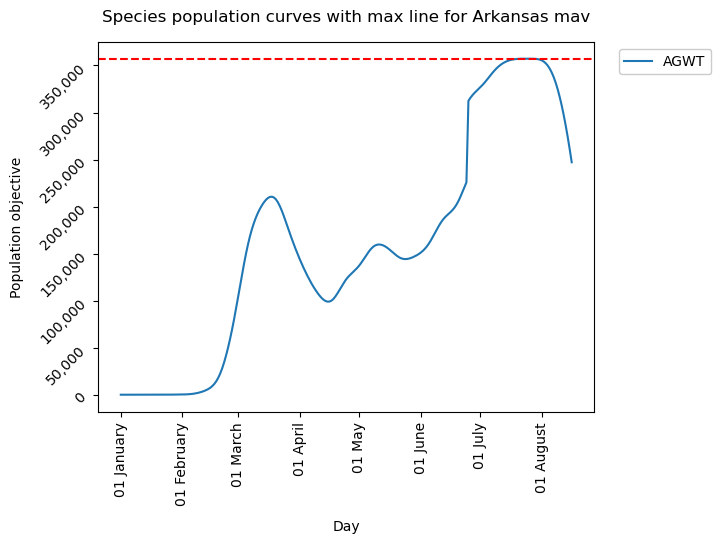

AMWI Arkansas_mav


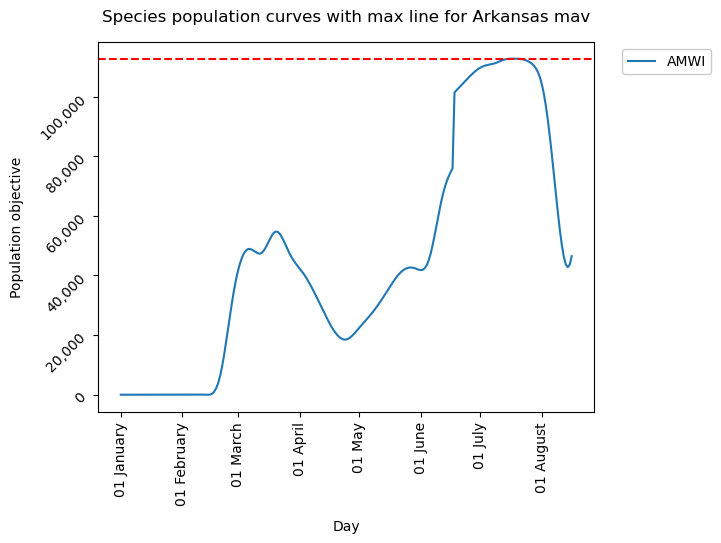

BWTE Arkansas_mav


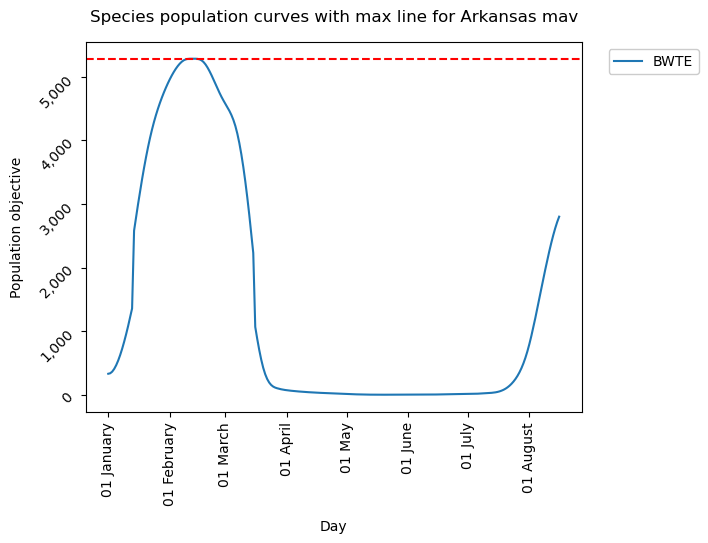

CANV Arkansas_mav


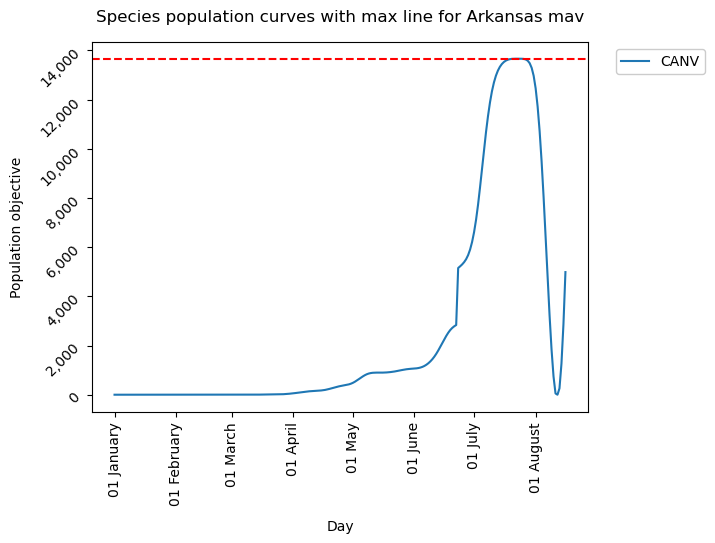

GADW Arkansas_mav


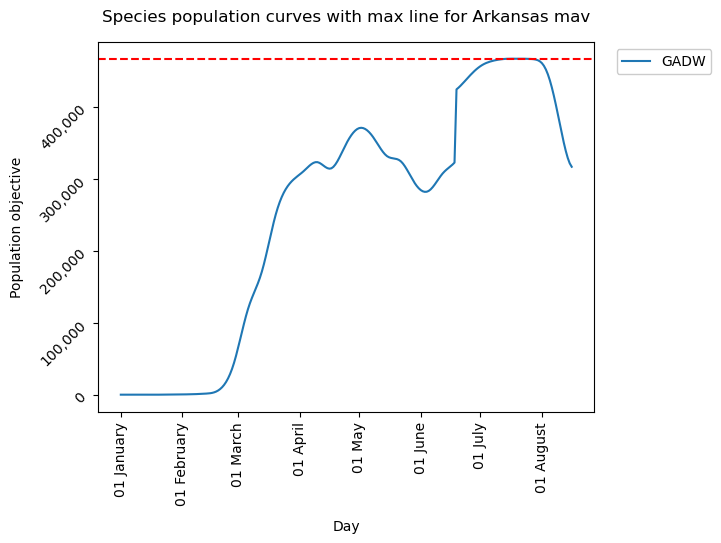

MALL Arkansas_mav


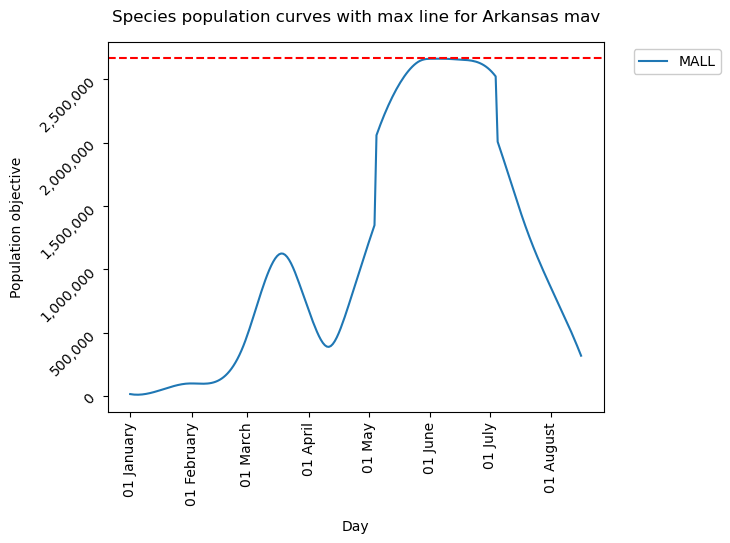

NOPI Arkansas_mav


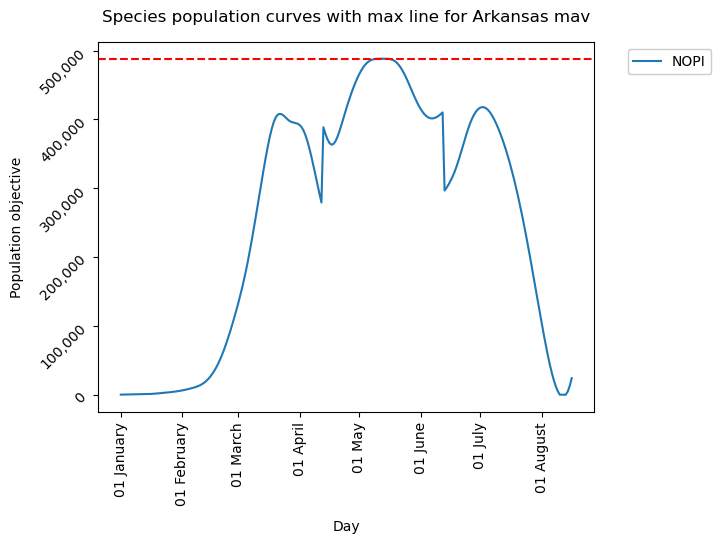

NSHO Arkansas_mav


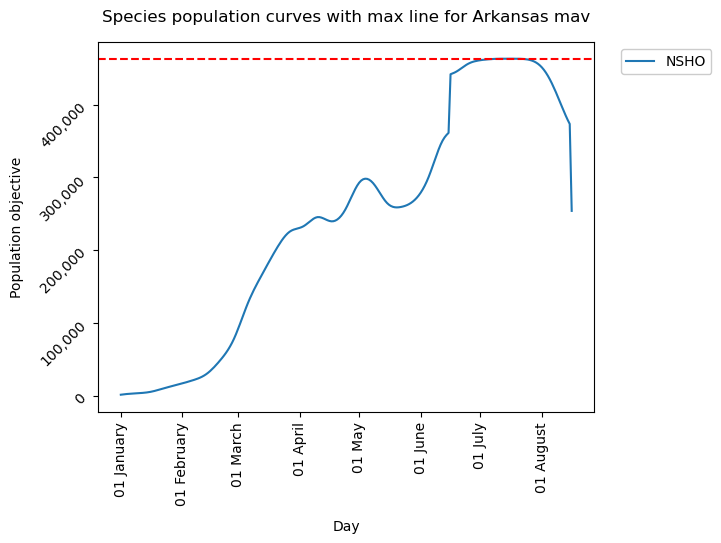

REDH Arkansas_mav


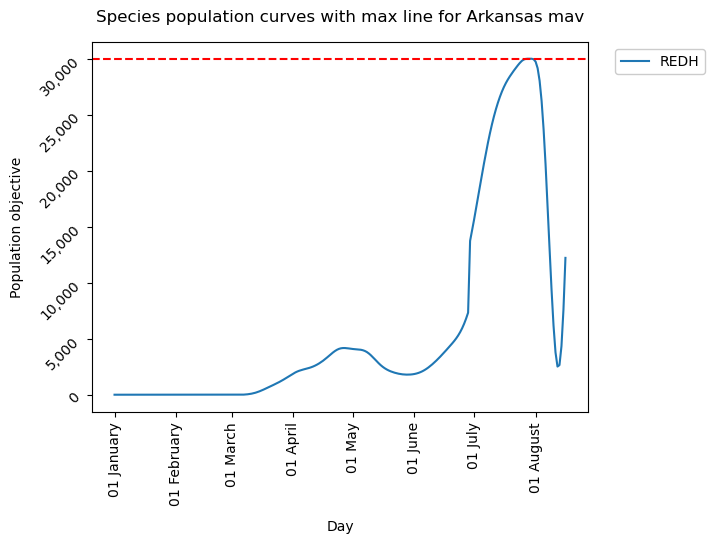

RNDU Arkansas_mav


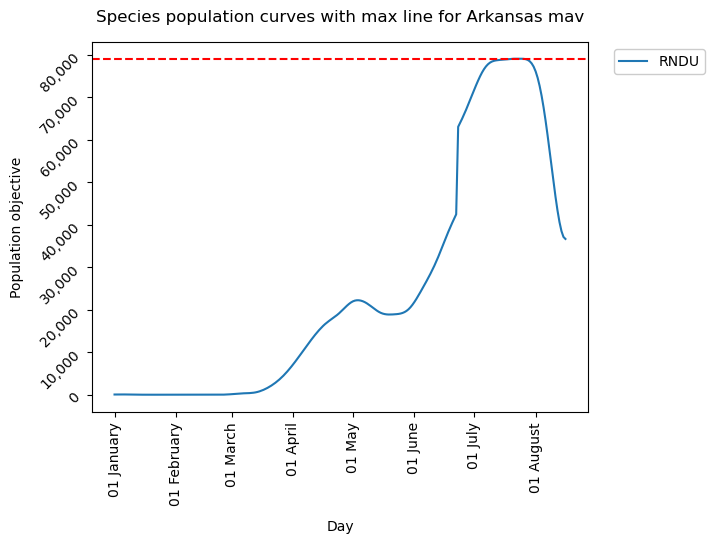

SCAU Arkansas_mav


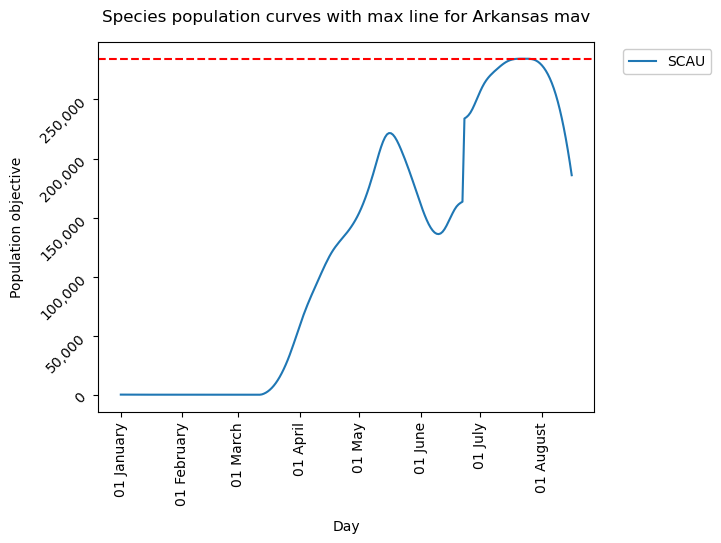

WODU Arkansas_mav


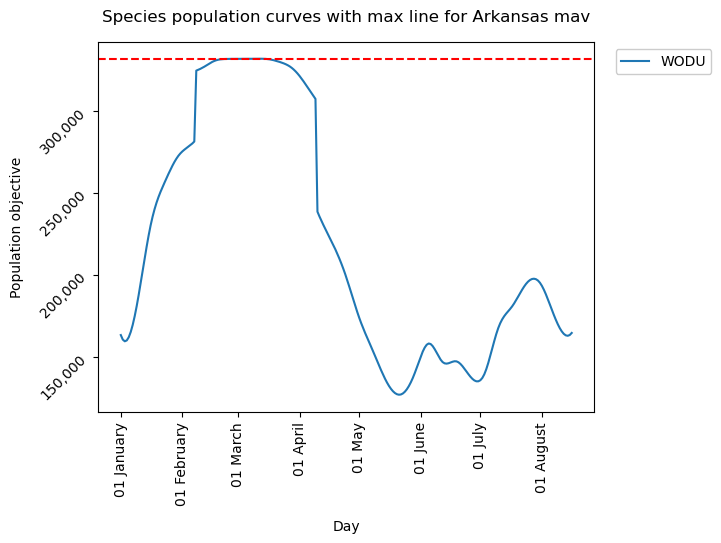

AGWT Arkansas_wg


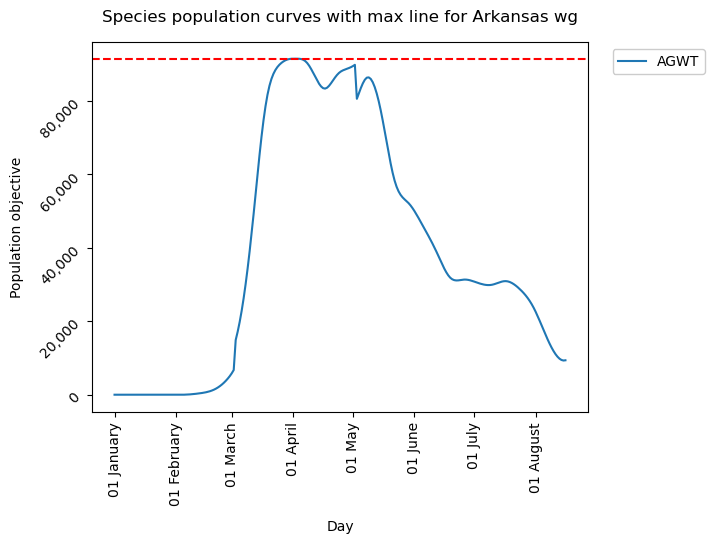

AMWI Arkansas_wg


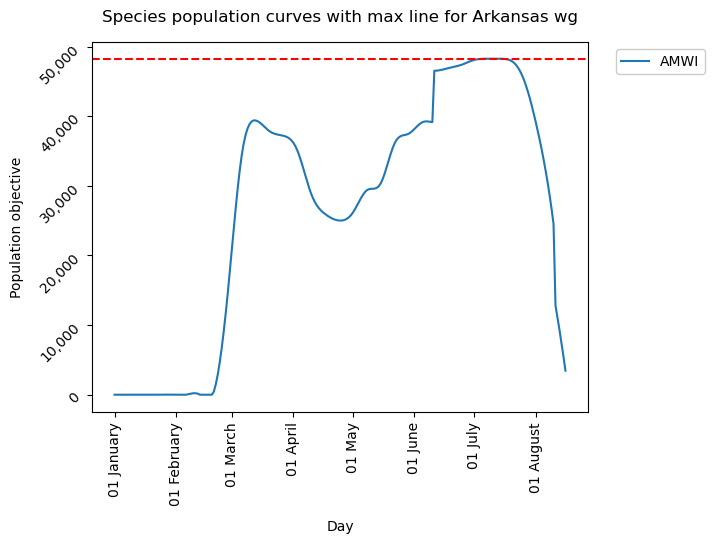

BWTE Arkansas_wg


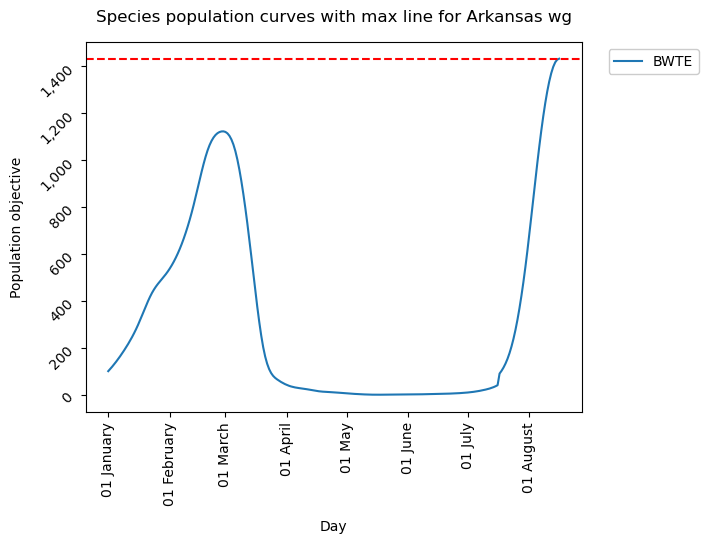

CANV Arkansas_wg


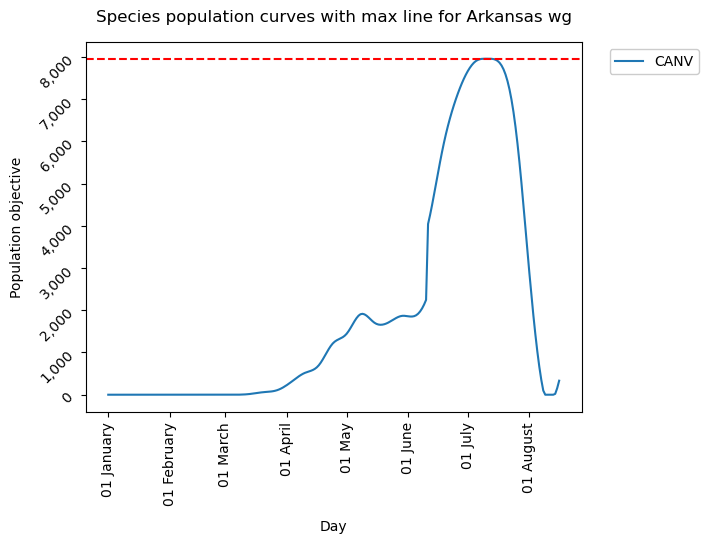

GADW Arkansas_wg


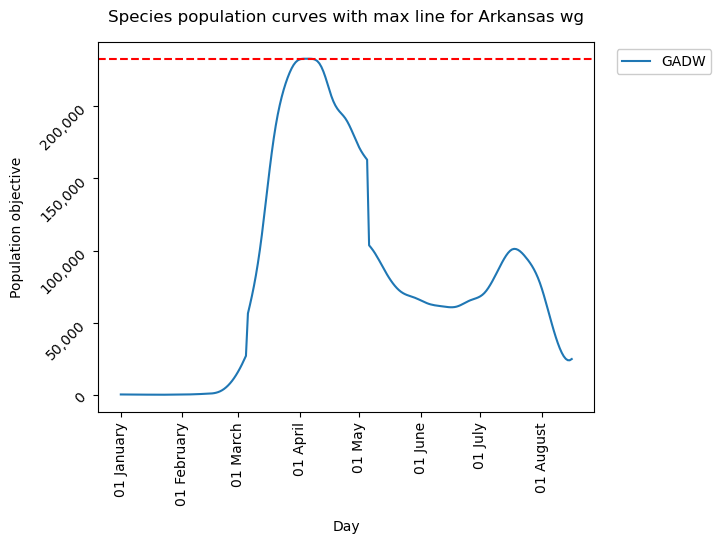

MALL Arkansas_wg


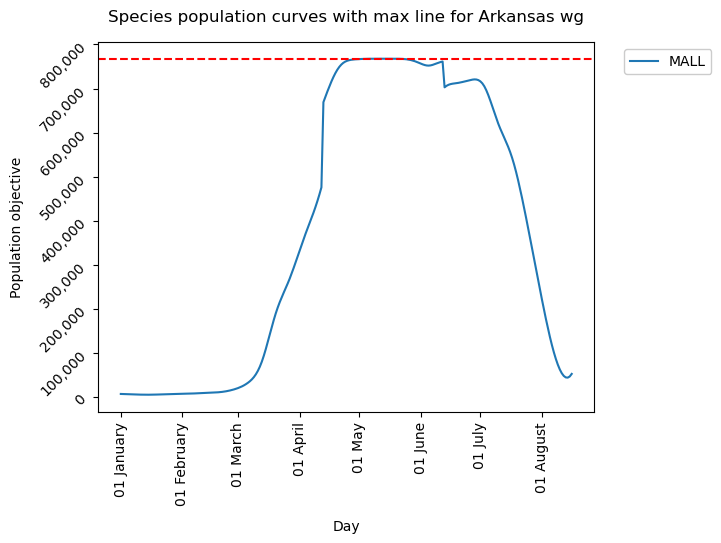

NOPI Arkansas_wg


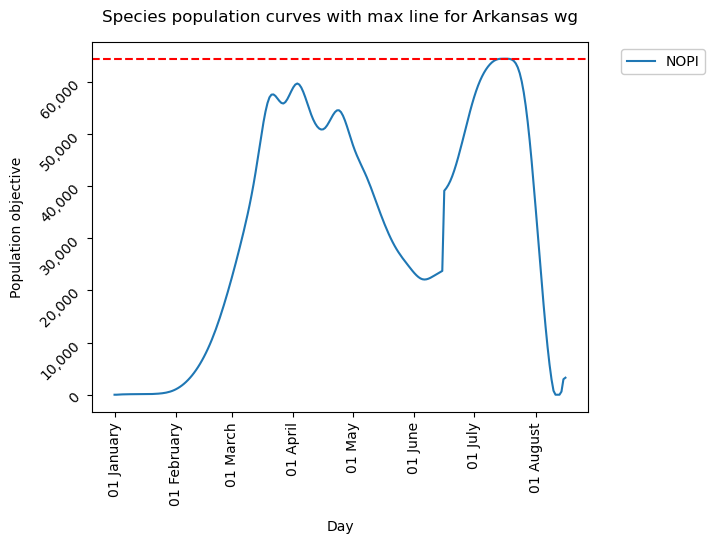

NSHO Arkansas_wg


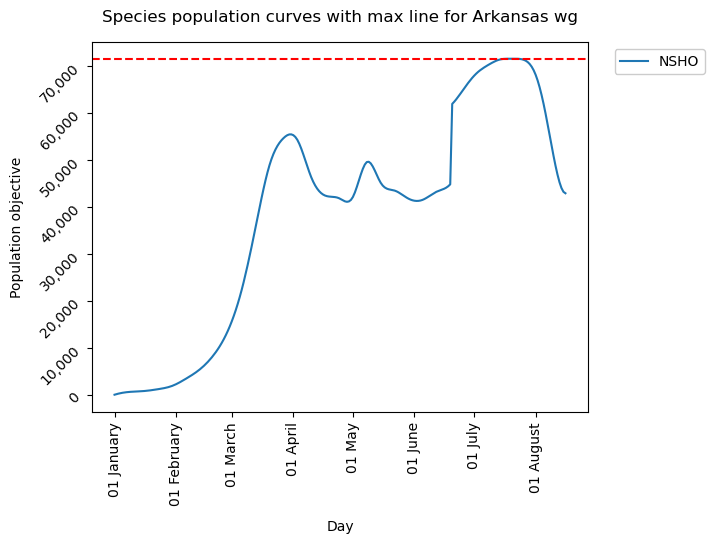

REDH Arkansas_wg


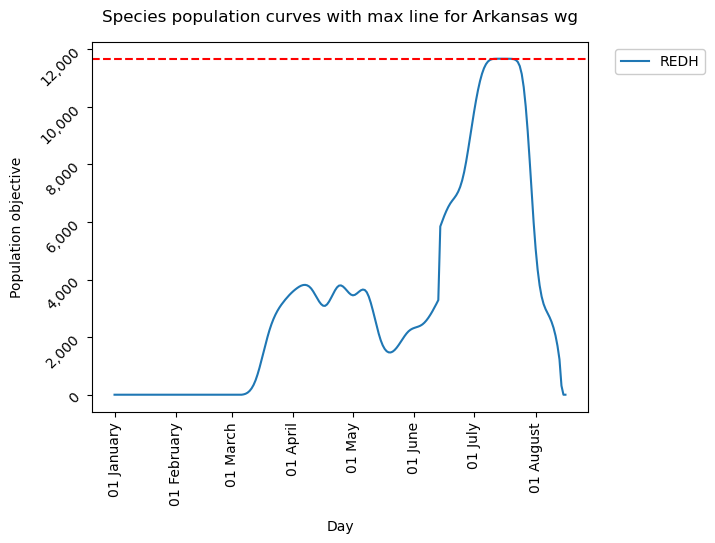

RNDU Arkansas_wg


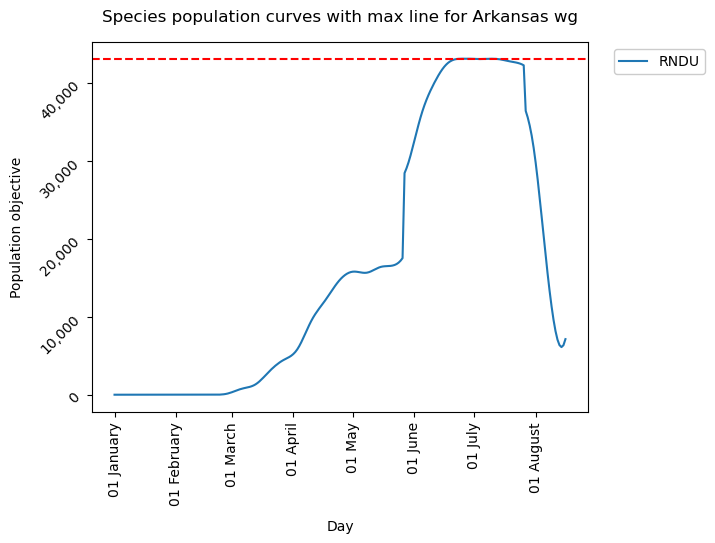

SCAU Arkansas_wg


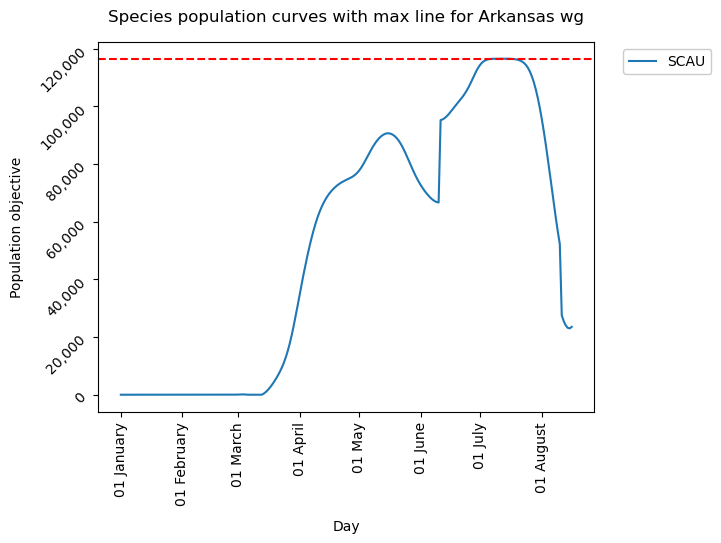

WODU Arkansas_wg


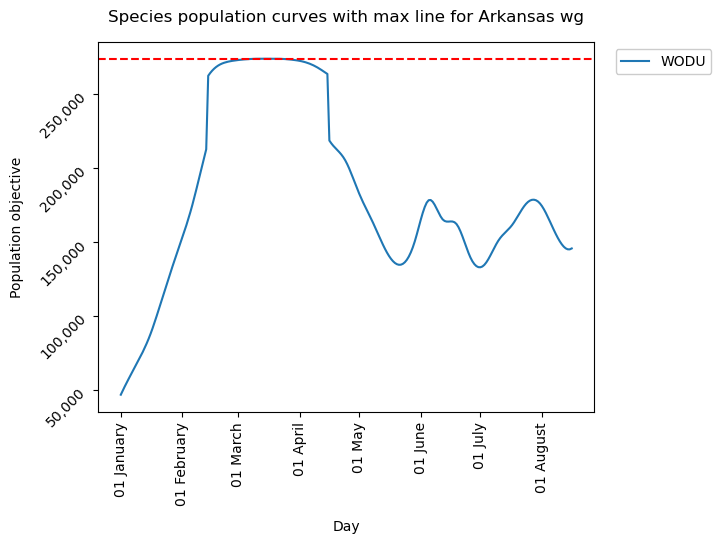

AGWT Kentucky


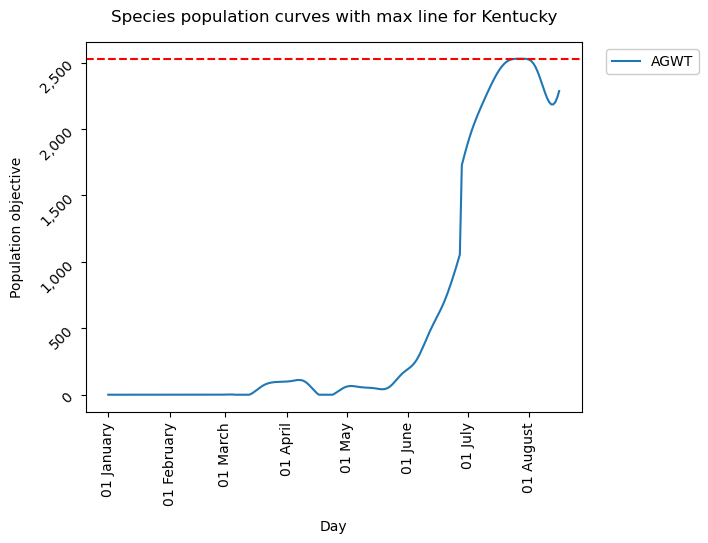

AMWI Kentucky


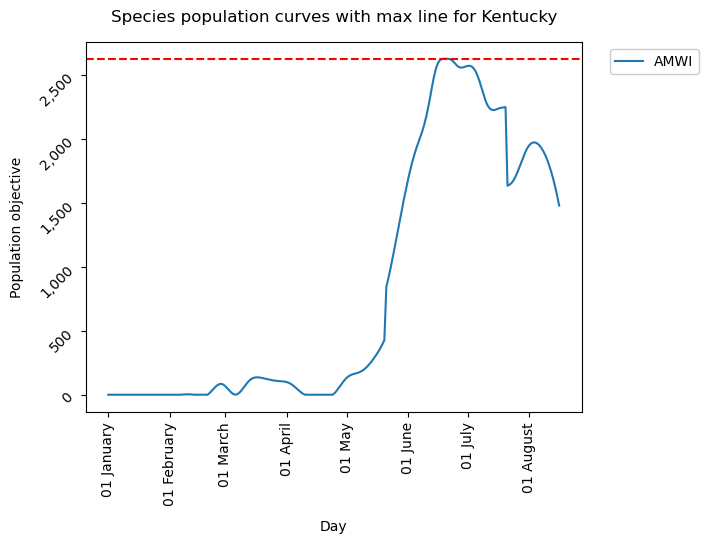

BWTE Kentucky


IndexError: single positional indexer is out-of-bounds

In [50]:
import warnings

# Suppress all warnings
warnings.filterwarnings('ignore')

start_date = datetime(2024, 8, 15)  # Starting date
days = list(range(1, 229))  # Days 1 to 200
dates = [start_date + timedelta(days=day - 1) for day in days]

#stbcr = 'Mississippi'
for stbcr in list(curveforplot['statebcr'].unique()):
    for sp in list(curveforplot['species'].unique()):
        print(sp, stbcr)
        ct = curveforplot[curveforplot['statebcr']==stbcr]
        tmp = ct.drop(columns='max').groupby('species').sum().drop(columns='statebcr')
        maxsp = ct[['statebcr', 'max', 'species']].groupby('species').sum().drop(columns='statebcr')
        maxsp = maxsp.reset_index()
        maxsp = maxsp[maxsp['species']==sp]
        tmp = tmp.reset_index()
        tmp = tmp[tmp['species']==sp]
        tmp = tmp.drop(['species'], axis=1).transpose().reset_index()
        y_values = tmp.iloc[:,1]

        max_y = max(y_values)
        center = np.argmax(y_values)  # Index of maximum y-value
        window = 30  # Number of points to smooth around the peak
        for i in range(center - window, center + window + 1):
            if 0 <= i < len(y_values):  # Avoid index errors
                y_values[i] = max_y - (max_y - y_values[i]) ** 2 / max_y
        plt.plot(tmp['index'],y_values, label=sp)
        plt.axhline(y=maxsp['max'].values[0], linestyle='--', color='red', label='_')
        plt.legend(framealpha=1, bbox_to_anchor=(1.25, 1),loc='upper right')
        plt.ticklabel_format(style='plain', axis='y')
        plt.xticks(np.arange(0, 230, step=20), rotation='vertical')
        plt.title('Species population curves with max line for {0}'.format(stbcr.replace('_', ' ')), pad=15)
        plt.xlabel('Day', labelpad=10)
        plt.ylabel('Population objective', labelpad=10)
        plt.yticks(rotation=45)
        plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d %B'))  # Format: "08/15"
        plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Major ticks at the start of each month
        plt.savefig('./plots/{0}_{1}_popcurve.png'.format(stbcr, sp), bbox_inches='tight')
        plt.show()